### Repeated Prisioner's Dilemma (Single Agent)

- There is one agent that interact in repeated prisioner's dilemma. 
- Actions are: defect (D/0) or cooperate (C/1).
- Defect is dominant strategy, and (D,D) is Nash Eqbm of stage game. 
- Sustained Cooperation is best for everyone in repeated game. 
- Opponent plays tit-for-tat or repeats whatever was played in previous turn. 
- Rewards for agents are 

    - (1,1) for (D,D) 
    - (3,0) for (D,C) 
    - (0,3) for (C,D) 
    - (2.5,2.5) for (C,C)

- There is just one state that does not change. State does not play a role here, it is just a placeholder. 
- There is "discounting". Agents value future profits - they do not seek to maximize discounted sum. 

### Import Packages

In [2]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [32]:
def gameReward(a1,a2):
    if (a1 == 0 and a2 == 0): # DD
        return (1,1)
    if (a1 == 0 and a2 == 1): # DC
        return (3,0)
    if (a1 == 1 and a2 == 0): # CD
        return (0,3)
    if (a1 == 1 and a2 == 1): # CC
        return (2.5,2.5)
   
def deterministicBot(a1_old):
    if (a1_old == 0): 
        return 0
    if (a1_old == 1): 
        return 1
    
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','a2','r1','r2'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State, Output: Value of actions (0/1)
    # Network predicts the expected Return of taking each action given the state
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   


def select_action(state, policy_net, idx):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice([0,1])
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)
    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')
        
    

### HyperParameters and Initializations

In [57]:
BATCH_SIZE = 512 # number of transitions sampled from replay buffer
GAMMA = 0.99 # Discount factor
EPS_START = 0.99 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.0001 # update rate of target network
LR = 1e-5 # Learning rate of Adam
n_obs = 1
n_actions = 2
policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
steps_done1 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

### Training Loop

In [58]:
state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
epochs = 10000

state = torch.tensor(int(0),dtype=torch.float32).unsqueeze(0)
a1 = torch.tensor(int(0),dtype=torch.float32).unsqueeze(0)

for t in range(epochs):
    print('\n Iteration:',t)
    
    # Take action
    a2 = deterministicBot(int(a1)) # bot takes action based off past policy
    a1 = select_action(state, policy_net1, 0)

    # Obtain Rewards
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])

    # Compute next state (which is the opponents' strategy)
    next_state = torch.tensor(int(a2),dtype=torch.float32).unsqueeze(0)

    # store memory in transition
    memory.push(state,next_state,a1,a2,r1,r2)

    # move to next state
    state = next_state

    # optimize
    optimize_model(policy_net1,target_net1, 0)

    # soft update target_net
    update_target_net(target_net1, policy_net1)
    
    # record actions
    actions.append([int(a1),int(a2)])
    
    with torch.no_grad():
        temp1 = torch.tensor(int(0),dtype=torch.float32).unsqueeze(0)
        temp2 = torch.tensor(int(1),dtype=torch.float32).unsqueeze(0)

        print(policy_net1(temp1))
        print(policy_net1(temp2))


 Iteration: 0
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 1
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 2
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 3
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 4
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 5
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 6
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 7
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 8
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 9
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 10
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 11
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 12
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 13
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 14
tensor([-0.181

tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 186
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 187
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 188
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 189
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 190
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 191
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 192
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 193
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 194
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 195
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 196
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 197
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 198
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 199
tensor

tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 324
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 325
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 326
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 327
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 328
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 329
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 330
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 331
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 332
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 333
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 334
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 335
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 336
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 337
tensor

tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 475
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 476
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 477
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 478
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 479
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 480
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 481
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 482
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 483
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 484
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 485
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 486
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 487
tensor([-0.1810, -0.0247])
tensor([-0.1753,  0.0094])

 Iteration: 488
tensor

Loss Agent0:1.470254898071289
tensor([-0.1500,  0.0152])
tensor([-0.1299,  0.0648])

 Iteration: 572
Loss Agent0:1.4727619886398315
tensor([-0.1495,  0.0158])
tensor([-0.1293,  0.0657])

 Iteration: 573
Loss Agent0:1.482738733291626
tensor([-0.1491,  0.0165])
tensor([-0.1286,  0.0667])

 Iteration: 574
Loss Agent0:1.5174720287322998
tensor([-0.1486,  0.0172])
tensor([-0.1279,  0.0676])

 Iteration: 575
Loss Agent0:1.5039618015289307
tensor([-0.1481,  0.0178])
tensor([-0.1272,  0.0685])

 Iteration: 576
Loss Agent0:1.4620282649993896
tensor([-0.1476,  0.0185])
tensor([-0.1266,  0.0695])

 Iteration: 577
Loss Agent0:1.499241828918457
tensor([-0.1471,  0.0192])
tensor([-0.1259,  0.0705])

 Iteration: 578
Loss Agent0:1.463440179824829
tensor([-0.1466,  0.0199])
tensor([-0.1253,  0.0714])

 Iteration: 579
Loss Agent0:1.5025948286056519
tensor([-0.1461,  0.0205])
tensor([-0.1246,  0.0724])

 Iteration: 580
Loss Agent0:1.4589183330535889
tensor([-0.1457,  0.0212])
tensor([-0.1240,  0.0734])



Loss Agent0:1.438819408416748
tensor([-0.1078,  0.0798])
tensor([-0.0737,  0.1655])

 Iteration: 669
Loss Agent0:1.4092426300048828
tensor([-0.1074,  0.0804])
tensor([-0.0731,  0.1665])

 Iteration: 670
Loss Agent0:1.4605329036712646
tensor([-0.1070,  0.0811])
tensor([-0.0724,  0.1675])

 Iteration: 671
Loss Agent0:1.4523231983184814
tensor([-0.1066,  0.0817])
tensor([-0.0718,  0.1684])

 Iteration: 672
Loss Agent0:1.4492743015289307
tensor([-0.1062,  0.0824])
tensor([-0.0711,  0.1694])

 Iteration: 673
Loss Agent0:1.4560487270355225
tensor([-0.1058,  0.0831])
tensor([-0.0705,  0.1703])

 Iteration: 674
Loss Agent0:1.442126750946045
tensor([-0.1055,  0.0837])
tensor([-0.0699,  0.1713])

 Iteration: 675
Loss Agent0:1.4491468667984009
tensor([-0.1051,  0.0844])
tensor([-0.0692,  0.1723])

 Iteration: 676
Loss Agent0:1.4461413621902466
tensor([-0.1047,  0.0851])
tensor([-0.0686,  0.1732])

 Iteration: 677
Loss Agent0:1.429071307182312
tensor([-0.1043,  0.0858])
tensor([-0.0679,  0.1742])


Loss Agent0:1.3859444856643677
tensor([-0.0686,  0.1568])
tensor([-0.0109,  0.2737])

 Iteration: 769
Loss Agent0:1.4198603630065918
tensor([-0.0682,  0.1576])
tensor([-0.0103,  0.2747])

 Iteration: 770
Loss Agent0:1.3824265003204346
tensor([-0.0678,  0.1583])
tensor([-0.0096,  0.2758])

 Iteration: 771
Loss Agent0:1.4244080781936646
tensor([-0.0674,  0.1591])
tensor([-0.0089,  0.2768])

 Iteration: 772
Loss Agent0:1.3687971830368042
tensor([-0.0670,  0.1599])
tensor([-0.0082,  0.2778])

 Iteration: 773
Loss Agent0:1.3753457069396973
tensor([-0.0666,  0.1607])
tensor([-0.0076,  0.2789])

 Iteration: 774
Loss Agent0:1.407126545906067
tensor([-0.0662,  0.1614])
tensor([-0.0069,  0.2799])

 Iteration: 775
Loss Agent0:1.3970454931259155
tensor([-0.0658,  0.1622])
tensor([-0.0062,  0.2810])

 Iteration: 776
Loss Agent0:1.4054439067840576
tensor([-0.0654,  0.1630])
tensor([-0.0055,  0.2820])

 Iteration: 777
Loss Agent0:1.404980182647705
tensor([-0.0650,  0.1638])
tensor([-0.0048,  0.2830])

Loss Agent0:1.40940260887146
tensor([-0.0388,  0.2236])
tensor([0.0448, 0.3623])

 Iteration: 852
Loss Agent0:1.3224530220031738
tensor([-0.0384,  0.2244])
tensor([0.0454, 0.3633])

 Iteration: 853
Loss Agent0:1.372175931930542
tensor([-0.0381,  0.2252])
tensor([0.0461, 0.3644])

 Iteration: 854
Loss Agent0:1.3574540615081787
tensor([-0.0377,  0.2260])
tensor([0.0467, 0.3655])

 Iteration: 855
Loss Agent0:1.3735953569412231
tensor([-0.0374,  0.2268])
tensor([0.0473, 0.3666])

 Iteration: 856
Loss Agent0:1.384893536567688
tensor([-0.0370,  0.2276])
tensor([0.0480, 0.3677])

 Iteration: 857
Loss Agent0:1.332235336303711
tensor([-0.0367,  0.2284])
tensor([0.0486, 0.3688])

 Iteration: 858
Loss Agent0:1.356931447982788
tensor([-0.0363,  0.2292])
tensor([0.0492, 0.3699])

 Iteration: 859
Loss Agent0:1.332788348197937
tensor([-0.0359,  0.2301])
tensor([0.0498, 0.3710])

 Iteration: 860
Loss Agent0:1.3729716539382935
tensor([-0.0356,  0.2309])
tensor([0.0505, 0.3721])

 Iteration: 861
Loss Ag

Loss Agent0:1.3757789134979248
tensor([-0.0046,  0.2946])
tensor([0.1034, 0.4620])

 Iteration: 943
Loss Agent0:1.3367031812667847
tensor([-0.0042,  0.2953])
tensor([0.1041, 0.4631])

 Iteration: 944
Loss Agent0:1.301247477531433
tensor([-0.0039,  0.2961])
tensor([0.1048, 0.4642])

 Iteration: 945
Loss Agent0:1.315844178199768
tensor([-0.0035,  0.2968])
tensor([0.1055, 0.4652])

 Iteration: 946
Loss Agent0:1.305498480796814
tensor([-0.0031,  0.2976])
tensor([0.1062, 0.4663])

 Iteration: 947
Loss Agent0:1.3180396556854248
tensor([-0.0027,  0.2984])
tensor([0.1069, 0.4674])

 Iteration: 948
Loss Agent0:1.2908668518066406
tensor([-0.0024,  0.2991])
tensor([0.1076, 0.4685])

 Iteration: 949
Loss Agent0:1.3166638612747192
tensor([-0.0020,  0.2999])
tensor([0.1083, 0.4695])

 Iteration: 950
Loss Agent0:1.3254221677780151
tensor([-0.0016,  0.3006])
tensor([0.1090, 0.4706])

 Iteration: 951
Loss Agent0:1.3065578937530518
tensor([-0.0012,  0.3013])
tensor([0.1097, 0.4716])

 Iteration: 952
Los

Loss Agent0:1.277733325958252
tensor([0.0322, 0.3691])
tensor([0.1670, 0.5699])

 Iteration: 1039
Loss Agent0:1.280057430267334
tensor([0.0327, 0.3699])
tensor([0.1676, 0.5711])

 Iteration: 1040
Loss Agent0:1.2357600927352905
tensor([0.0331, 0.3707])
tensor([0.1683, 0.5723])

 Iteration: 1041
Loss Agent0:1.3263437747955322
tensor([0.0335, 0.3715])
tensor([0.1689, 0.5735])

 Iteration: 1042
Loss Agent0:1.310808777809143
tensor([0.0339, 0.3724])
tensor([0.1695, 0.5747])

 Iteration: 1043
Loss Agent0:1.2936410903930664
tensor([0.0343, 0.3732])
tensor([0.1701, 0.5759])

 Iteration: 1044
Loss Agent0:1.2859814167022705
tensor([0.0347, 0.3740])
tensor([0.1708, 0.5771])

 Iteration: 1045
Loss Agent0:1.2752630710601807
tensor([0.0351, 0.3748])
tensor([0.1714, 0.5783])

 Iteration: 1046
Loss Agent0:1.302823781967163
tensor([0.0356, 0.3756])
tensor([0.1721, 0.5795])

 Iteration: 1047
Loss Agent0:1.2407946586608887
tensor([0.0360, 0.3764])
tensor([0.1728, 0.5807])

 Iteration: 1048
Loss Agent0:1.

tensor([0.2267, 0.6867])

 Iteration: 1136
Loss Agent0:1.183990478515625
tensor([0.0721, 0.4509])
tensor([0.2272, 0.6880])

 Iteration: 1137
Loss Agent0:1.2106800079345703
tensor([0.0725, 0.4518])
tensor([0.2278, 0.6892])

 Iteration: 1138
Loss Agent0:1.1803886890411377
tensor([0.0729, 0.4526])
tensor([0.2284, 0.6905])

 Iteration: 1139
Loss Agent0:1.2261872291564941
tensor([0.0733, 0.4535])
tensor([0.2289, 0.6917])

 Iteration: 1140
Loss Agent0:1.2573413848876953
tensor([0.0737, 0.4544])
tensor([0.2295, 0.6930])

 Iteration: 1141
Loss Agent0:1.2366584539413452
tensor([0.0741, 0.4553])
tensor([0.2301, 0.6943])

 Iteration: 1142
Loss Agent0:1.2102652788162231
tensor([0.0745, 0.4562])
tensor([0.2306, 0.6955])

 Iteration: 1143
Loss Agent0:1.2548260688781738
tensor([0.0749, 0.4571])
tensor([0.2312, 0.6968])

 Iteration: 1144
Loss Agent0:1.2360421419143677
tensor([0.0753, 0.4579])
tensor([0.2318, 0.6981])

 Iteration: 1145
Loss Agent0:1.2632241249084473
tensor([0.0757, 0.4588])
tensor([0.2

Loss Agent0:1.1596431732177734
tensor([0.1095, 0.5276])
tensor([0.2811, 0.7986])

 Iteration: 1225
Loss Agent0:1.161655068397522
tensor([0.1099, 0.5285])
tensor([0.2817, 0.7999])

 Iteration: 1226
Loss Agent0:1.1742135286331177
tensor([0.1104, 0.5294])
tensor([0.2824, 0.8011])

 Iteration: 1227
Loss Agent0:1.232513666152954
tensor([0.1109, 0.5302])
tensor([0.2831, 0.8024])

 Iteration: 1228
Loss Agent0:1.1846791505813599
tensor([0.1113, 0.5311])
tensor([0.2837, 0.8036])

 Iteration: 1229
Loss Agent0:1.1595221757888794
tensor([0.1118, 0.5319])
tensor([0.2844, 0.8049])

 Iteration: 1230
Loss Agent0:1.1532963514328003
tensor([0.1123, 0.5328])
tensor([0.2851, 0.8061])

 Iteration: 1231
Loss Agent0:1.139417052268982
tensor([0.1127, 0.5336])
tensor([0.2857, 0.8073])

 Iteration: 1232
Loss Agent0:1.1861937046051025
tensor([0.1132, 0.5345])
tensor([0.2864, 0.8086])

 Iteration: 1233
Loss Agent0:1.1536290645599365
tensor([0.1137, 0.5353])
tensor([0.2871, 0.8098])

 Iteration: 1234
Loss Agent0:1

tensor([0.1498, 0.6002])
tensor([0.3372, 0.9069])

 Iteration: 1310
Loss Agent0:1.099142074584961
tensor([0.1503, 0.6010])
tensor([0.3379, 0.9081])

 Iteration: 1311
Loss Agent0:1.119419813156128
tensor([0.1508, 0.6019])
tensor([0.3386, 0.9094])

 Iteration: 1312
Loss Agent0:1.1067830324172974
tensor([0.1512, 0.6027])
tensor([0.3392, 0.9107])

 Iteration: 1313
Loss Agent0:1.1371567249298096
tensor([0.1517, 0.6036])
tensor([0.3399, 0.9121])

 Iteration: 1314
Loss Agent0:1.1313754320144653
tensor([0.1522, 0.6044])
tensor([0.3406, 0.9134])

 Iteration: 1315
Loss Agent0:1.0947481393814087
tensor([0.1526, 0.6053])
tensor([0.3412, 0.9147])

 Iteration: 1316
Loss Agent0:1.1305030584335327
tensor([0.1531, 0.6062])
tensor([0.3419, 0.9160])

 Iteration: 1317
Loss Agent0:1.1103756427764893
tensor([0.1536, 0.6070])
tensor([0.3425, 0.9173])

 Iteration: 1318
Loss Agent0:1.1196502447128296
tensor([0.1540, 0.6079])
tensor([0.3432, 0.9185])

 Iteration: 1319
Loss Agent0:1.11029851436615
tensor([0.1545

Loss Agent0:1.0500273704528809
tensor([0.1914, 0.6786])
tensor([0.3976, 1.0256])

 Iteration: 1400
Loss Agent0:1.0718560218811035
tensor([0.1919, 0.6794])
tensor([0.3983, 1.0269])

 Iteration: 1401
Loss Agent0:1.0326098203659058
tensor([0.1924, 0.6803])
tensor([0.3991, 1.0282])

 Iteration: 1402
Loss Agent0:1.0564569234848022
tensor([0.1929, 0.6811])
tensor([0.3998, 1.0295])

 Iteration: 1403
Loss Agent0:1.014681339263916
tensor([0.1934, 0.6820])
tensor([0.4005, 1.0308])

 Iteration: 1404
Loss Agent0:1.0364270210266113
tensor([0.1939, 0.6828])
tensor([0.4012, 1.0321])

 Iteration: 1405
Loss Agent0:1.0656306743621826
tensor([0.1944, 0.6837])
tensor([0.4019, 1.0334])

 Iteration: 1406
Loss Agent0:1.0490151643753052
tensor([0.1949, 0.6845])
tensor([0.4026, 1.0347])

 Iteration: 1407
Loss Agent0:1.0679665803909302
tensor([0.1954, 0.6854])
tensor([0.4033, 1.0360])

 Iteration: 1408
Loss Agent0:1.0405304431915283
tensor([0.1958, 0.6862])
tensor([0.4041, 1.0372])

 Iteration: 1409
Loss Agent0

Loss Agent0:1.0117967128753662
tensor([0.2336, 0.7530])
tensor([0.4600, 1.1379])

 Iteration: 1485
Loss Agent0:0.9871673583984375
tensor([0.2340, 0.7540])
tensor([0.4607, 1.1393])

 Iteration: 1486
Loss Agent0:1.0532188415527344
tensor([0.2345, 0.7549])
tensor([0.4614, 1.1407])

 Iteration: 1487
Loss Agent0:1.0353548526763916
tensor([0.2350, 0.7559])
tensor([0.4622, 1.1422])

 Iteration: 1488
Loss Agent0:1.0178942680358887
tensor([0.2355, 0.7568])
tensor([0.4629, 1.1436])

 Iteration: 1489
Loss Agent0:0.9922857284545898
tensor([0.2360, 0.7578])
tensor([0.4636, 1.1450])

 Iteration: 1490
Loss Agent0:1.0055166482925415
tensor([0.2365, 0.7587])
tensor([0.4643, 1.1464])

 Iteration: 1491
Loss Agent0:1.0022119283676147
tensor([0.2369, 0.7596])
tensor([0.4650, 1.1478])

 Iteration: 1492
Loss Agent0:1.044525384902954
tensor([0.2374, 0.7606])
tensor([0.4658, 1.1492])

 Iteration: 1493
Loss Agent0:1.0255436897277832
tensor([0.2379, 0.7615])
tensor([0.4665, 1.1505])

 Iteration: 1494
Loss Agent0

Loss Agent0:0.9908404350280762
tensor([0.2822, 0.8409])
tensor([0.5330, 1.2692])

 Iteration: 1580
Loss Agent0:0.9530676603317261
tensor([0.2828, 0.8419])
tensor([0.5338, 1.2706])

 Iteration: 1581
Loss Agent0:0.9701880812644958
tensor([0.2833, 0.8428])
tensor([0.5346, 1.2721])

 Iteration: 1582
Loss Agent0:0.9608453512191772
tensor([0.2838, 0.8437])
tensor([0.5354, 1.2735])

 Iteration: 1583
Loss Agent0:0.9393054246902466
tensor([0.2844, 0.8446])
tensor([0.5362, 1.2749])

 Iteration: 1584
Loss Agent0:0.9023813605308533
tensor([0.2849, 0.8455])
tensor([0.5370, 1.2763])

 Iteration: 1585
Loss Agent0:0.9378606081008911
tensor([0.2854, 0.8465])
tensor([0.5378, 1.2777])

 Iteration: 1586
Loss Agent0:0.9848094582557678
tensor([0.2860, 0.8474])
tensor([0.5386, 1.2791])

 Iteration: 1587
Loss Agent0:0.9558072686195374
tensor([0.2865, 0.8483])
tensor([0.5393, 1.2805])

 Iteration: 1588
Loss Agent0:0.9440035223960876
tensor([0.2870, 0.8493])
tensor([0.5401, 1.2819])

 Iteration: 1589
Loss Agent

Loss Agent0:0.8706238269805908
tensor([0.3339, 0.9333])
tensor([0.6104, 1.4084])

 Iteration: 1676
Loss Agent0:0.8634226322174072
tensor([0.3345, 0.9343])
tensor([0.6112, 1.4099])

 Iteration: 1677
Loss Agent0:0.8625099062919617
tensor([0.3350, 0.9353])
tensor([0.6120, 1.4114])

 Iteration: 1678
Loss Agent0:0.857833981513977
tensor([0.3356, 0.9363])
tensor([0.6128, 1.4129])

 Iteration: 1679
Loss Agent0:0.8962832689285278
tensor([0.3361, 0.9373])
tensor([0.6136, 1.4145])

 Iteration: 1680
Loss Agent0:0.8866558074951172
tensor([0.3367, 0.9383])
tensor([0.6144, 1.4160])

 Iteration: 1681
Loss Agent0:0.8519531488418579
tensor([0.3372, 0.9393])
tensor([0.6153, 1.4175])

 Iteration: 1682
Loss Agent0:0.8481146693229675
tensor([0.3377, 0.9403])
tensor([0.6161, 1.4191])

 Iteration: 1683
Loss Agent0:0.8814350962638855
tensor([0.3383, 0.9414])
tensor([0.6169, 1.4206])

 Iteration: 1684
Loss Agent0:0.8518154621124268
tensor([0.3388, 0.9424])
tensor([0.6177, 1.4221])

 Iteration: 1685
Loss Agent0

Loss Agent0:0.8266132473945618
tensor([0.3804, 1.0167])
tensor([0.6798, 1.5356])

 Iteration: 1759
Loss Agent0:0.8363319039344788
tensor([0.3810, 1.0177])
tensor([0.6806, 1.5371])

 Iteration: 1760
Loss Agent0:0.802590548992157
tensor([0.3815, 1.0187])
tensor([0.6815, 1.5387])

 Iteration: 1761
Loss Agent0:0.8377708196640015
tensor([0.3821, 1.0197])
tensor([0.6824, 1.5402])

 Iteration: 1762
Loss Agent0:0.8133989572525024
tensor([0.3827, 1.0207])
tensor([0.6833, 1.5417])

 Iteration: 1763
Loss Agent0:0.773334264755249
tensor([0.3833, 1.0217])
tensor([0.6842, 1.5432])

 Iteration: 1764
Loss Agent0:0.8163745403289795
tensor([0.3839, 1.0227])
tensor([0.6850, 1.5448])

 Iteration: 1765
Loss Agent0:0.8465519547462463
tensor([0.3845, 1.0237])
tensor([0.6859, 1.5463])

 Iteration: 1766
Loss Agent0:0.8184606432914734
tensor([0.3851, 1.0247])
tensor([0.6868, 1.5478])

 Iteration: 1767
Loss Agent0:0.7865222692489624
tensor([0.3857, 1.0257])
tensor([0.6877, 1.5492])

 Iteration: 1768
Loss Agent0:

Loss Agent0:0.7841066122055054
tensor([0.4305, 1.0944])
tensor([0.7557, 1.6515])

 Iteration: 1842
Loss Agent0:0.7233729958534241
tensor([0.4311, 1.0953])
tensor([0.7567, 1.6528])

 Iteration: 1843
Loss Agent0:0.8234270811080933
tensor([0.4317, 1.0962])
tensor([0.7576, 1.6542])

 Iteration: 1844
Loss Agent0:0.7605748176574707
tensor([0.4324, 1.0971])
tensor([0.7586, 1.6555])

 Iteration: 1845
Loss Agent0:0.772982656955719
tensor([0.4330, 1.0980])
tensor([0.7596, 1.6568])

 Iteration: 1846
Loss Agent0:0.7479514479637146
tensor([0.4337, 1.0989])
tensor([0.7606, 1.6581])

 Iteration: 1847
Loss Agent0:0.7802757024765015
tensor([0.4343, 1.0998])
tensor([0.7615, 1.6594])

 Iteration: 1848
Loss Agent0:0.7582705616950989
tensor([0.4349, 1.1007])
tensor([0.7625, 1.6608])

 Iteration: 1849
Loss Agent0:0.7856293320655823
tensor([0.4356, 1.1016])
tensor([0.7634, 1.6620])

 Iteration: 1850
Loss Agent0:0.7468697428703308
tensor([0.4362, 1.1025])
tensor([0.7644, 1.6633])

 Iteration: 1851
Loss Agent0

Loss Agent0:0.7272799015045166
tensor([0.4853, 1.1707])
tensor([0.8385, 1.7615])

 Iteration: 1929
Loss Agent0:0.7187820076942444
tensor([0.4860, 1.1716])
tensor([0.8395, 1.7627])

 Iteration: 1930
Loss Agent0:0.7022691965103149
tensor([0.4866, 1.1724])
tensor([0.8405, 1.7639])

 Iteration: 1931
Loss Agent0:0.7286577820777893
tensor([0.4872, 1.1732])
tensor([0.8414, 1.7650])

 Iteration: 1932
Loss Agent0:0.679293692111969
tensor([0.4879, 1.1741])
tensor([0.8424, 1.7662])

 Iteration: 1933
Loss Agent0:0.7312132716178894
tensor([0.4885, 1.1749])
tensor([0.8433, 1.7674])

 Iteration: 1934
Loss Agent0:0.704515278339386
tensor([0.4891, 1.1757])
tensor([0.8443, 1.7686])

 Iteration: 1935
Loss Agent0:0.7133179903030396
tensor([0.4898, 1.1766])
tensor([0.8452, 1.7697])

 Iteration: 1936
Loss Agent0:0.7208622694015503
tensor([0.4904, 1.1774])
tensor([0.8462, 1.7709])

 Iteration: 1937
Loss Agent0:0.6847099661827087
tensor([0.4910, 1.1782])
tensor([0.8471, 1.7721])

 Iteration: 1938
Loss Agent0:

Loss Agent0:0.6185299158096313
tensor([0.5445, 1.2464])
tensor([0.9273, 1.8656])

 Iteration: 2023
Loss Agent0:0.6423895955085754
tensor([0.5451, 1.2471])
tensor([0.9282, 1.8666])

 Iteration: 2024
Loss Agent0:0.6209231615066528
tensor([0.5457, 1.2479])
tensor([0.9291, 1.8677])

 Iteration: 2025
Loss Agent0:0.6398171782493591
tensor([0.5463, 1.2487])
tensor([0.9300, 1.8688])

 Iteration: 2026
Loss Agent0:0.7002198100090027
tensor([0.5469, 1.2495])
tensor([0.9310, 1.8698])

 Iteration: 2027
Loss Agent0:0.6566154360771179
tensor([0.5476, 1.2503])
tensor([0.9319, 1.8709])

 Iteration: 2028
Loss Agent0:0.6755286455154419
tensor([0.5482, 1.2511])
tensor([0.9328, 1.8720])

 Iteration: 2029
Loss Agent0:0.6705114841461182
tensor([0.5488, 1.2519])
tensor([0.9338, 1.8730])

 Iteration: 2030
Loss Agent0:0.6419848799705505
tensor([0.5495, 1.2527])
tensor([0.9347, 1.8741])

 Iteration: 2031
Loss Agent0:0.6570164561271667
tensor([0.5501, 1.2535])
tensor([0.9356, 1.8751])

 Iteration: 2032
Loss Agent

Loss Agent0:0.6093699932098389
tensor([0.6006, 1.3116])
tensor([1.0109, 1.9524])

 Iteration: 2112
Loss Agent0:0.591168999671936
tensor([0.6012, 1.3123])
tensor([1.0118, 1.9534])

 Iteration: 2113
Loss Agent0:0.6205126643180847
tensor([0.6018, 1.3131])
tensor([1.0127, 1.9543])

 Iteration: 2114
Loss Agent0:0.6394274830818176
tensor([0.6024, 1.3138])
tensor([1.0136, 1.9552])

 Iteration: 2115
Loss Agent0:0.6177204847335815
tensor([0.6030, 1.3145])
tensor([1.0145, 1.9562])

 Iteration: 2116
Loss Agent0:0.5772170424461365
tensor([0.6036, 1.3152])
tensor([1.0154, 1.9571])

 Iteration: 2117
Loss Agent0:0.6016236543655396
tensor([0.6042, 1.3159])
tensor([1.0163, 1.9580])

 Iteration: 2118
Loss Agent0:0.6058364510536194
tensor([0.6048, 1.3167])
tensor([1.0172, 1.9590])

 Iteration: 2119
Loss Agent0:0.5888040661811829
tensor([0.6054, 1.3174])
tensor([1.0181, 1.9599])

 Iteration: 2120
Loss Agent0:0.6458592414855957
tensor([0.6060, 1.3181])
tensor([1.0190, 1.9609])

 Iteration: 2121
Loss Agent0

Loss Agent0:0.5554883480072021
tensor([0.6584, 1.3752])
tensor([1.0971, 2.0333])

 Iteration: 2204
Loss Agent0:0.6129470467567444
tensor([0.6591, 1.3758])
tensor([1.0980, 2.0341])

 Iteration: 2205
Loss Agent0:0.5995340347290039
tensor([0.6597, 1.3765])
tensor([1.0989, 2.0350])

 Iteration: 2206
Loss Agent0:0.6070919632911682
tensor([0.6604, 1.3772])
tensor([1.0999, 2.0358])

 Iteration: 2207
Loss Agent0:0.6118130683898926
tensor([0.6610, 1.3778])
tensor([1.1008, 2.0366])

 Iteration: 2208
Loss Agent0:0.5553669333457947
tensor([0.6616, 1.3785])
tensor([1.1018, 2.0374])

 Iteration: 2209
Loss Agent0:0.5902051329612732
tensor([0.6622, 1.3792])
tensor([1.1027, 2.0382])

 Iteration: 2210
Loss Agent0:0.5604491829872131
tensor([0.6629, 1.3799])
tensor([1.1036, 2.0390])

 Iteration: 2211
Loss Agent0:0.5580285787582397
tensor([0.6635, 1.3806])
tensor([1.1045, 2.0399])

 Iteration: 2212
Loss Agent0:0.6047424077987671
tensor([0.6641, 1.3813])
tensor([1.1054, 2.0407])

 Iteration: 2213
Loss Agent

Loss Agent0:0.5990971922874451
tensor([0.7159, 1.4328])
tensor([1.1815, 2.1027])

 Iteration: 2293
Loss Agent0:0.5906182527542114
tensor([0.7166, 1.4334])
tensor([1.1825, 2.1034])

 Iteration: 2294
Loss Agent0:0.5802599191665649
tensor([0.7173, 1.4340])
tensor([1.1835, 2.1041])

 Iteration: 2295
Loss Agent0:0.5526784062385559
tensor([0.7179, 1.4346])
tensor([1.1844, 2.1048])

 Iteration: 2296
Loss Agent0:0.5329959392547607
tensor([0.7186, 1.4352])
tensor([1.1854, 2.1055])

 Iteration: 2297
Loss Agent0:0.5421292781829834
tensor([0.7193, 1.4358])
tensor([1.1864, 2.1062])

 Iteration: 2298
Loss Agent0:0.5512906908988953
tensor([0.7199, 1.4364])
tensor([1.1873, 2.1069])

 Iteration: 2299
Loss Agent0:0.5954653024673462
tensor([0.7206, 1.4369])
tensor([1.1883, 2.1076])

 Iteration: 2300
Loss Agent0:0.5553799271583557
tensor([0.7212, 1.4375])
tensor([1.1893, 2.1083])

 Iteration: 2301
Loss Agent0:0.5920584201812744
tensor([0.7219, 1.4381])
tensor([1.1902, 2.1090])

 Iteration: 2302
Loss Agent

Loss Agent0:0.4820842146873474
tensor([0.7732, 1.4839])
tensor([1.2650, 2.1610])

 Iteration: 2382
Loss Agent0:0.5003760457038879
tensor([0.7738, 1.4844])
tensor([1.2659, 2.1617])

 Iteration: 2383
Loss Agent0:0.5408552885055542
tensor([0.7745, 1.4849])
tensor([1.2668, 2.1623])

 Iteration: 2384
Loss Agent0:0.5446747541427612
tensor([0.7751, 1.4855])
tensor([1.2677, 2.1629])

 Iteration: 2385
Loss Agent0:0.5487750768661499
tensor([0.7757, 1.4860])
tensor([1.2686, 2.1635])

 Iteration: 2386
Loss Agent0:0.5824578404426575
tensor([0.7764, 1.4865])
tensor([1.2695, 2.1640])

 Iteration: 2387
Loss Agent0:0.5850208401679993
tensor([0.7770, 1.4871])
tensor([1.2704, 2.1646])

 Iteration: 2388
Loss Agent0:0.5346274375915527
tensor([0.7776, 1.4876])
tensor([1.2714, 2.1652])

 Iteration: 2389
Loss Agent0:0.5618934035301208
tensor([0.7783, 1.4881])
tensor([1.2723, 2.1657])

 Iteration: 2390
Loss Agent0:0.5125576853752136
tensor([0.7789, 1.4886])
tensor([1.2732, 2.1663])

 Iteration: 2391
Loss Agent

Loss Agent0:0.4926864206790924
tensor([0.8341, 1.5308])
tensor([1.3530, 2.2102])

 Iteration: 2477
Loss Agent0:0.5151810050010681
tensor([0.8348, 1.5313])
tensor([1.3540, 2.2106])

 Iteration: 2478
Loss Agent0:0.5315330028533936
tensor([0.8354, 1.5317])
tensor([1.3549, 2.2111])

 Iteration: 2479
Loss Agent0:0.48985880613327026
tensor([0.8360, 1.5322])
tensor([1.3558, 2.2115])

 Iteration: 2480
Loss Agent0:0.5007719397544861
tensor([0.8367, 1.5326])
tensor([1.3567, 2.2120])

 Iteration: 2481
Loss Agent0:0.533308207988739
tensor([0.8373, 1.5331])
tensor([1.3577, 2.2124])

 Iteration: 2482
Loss Agent0:0.5322738885879517
tensor([0.8380, 1.5335])
tensor([1.3586, 2.2129])

 Iteration: 2483
Loss Agent0:0.5063848495483398
tensor([0.8386, 1.5339])
tensor([1.3595, 2.2133])

 Iteration: 2484
Loss Agent0:0.541411817073822
tensor([0.8392, 1.5344])
tensor([1.3605, 2.2137])

 Iteration: 2485
Loss Agent0:0.4752923548221588
tensor([0.8399, 1.5348])
tensor([1.3614, 2.2142])

 Iteration: 2486
Loss Agent0

Loss Agent0:0.4624798893928528
tensor([0.8898, 1.5684])
tensor([1.4327, 2.2471])

 Iteration: 2565
Loss Agent0:0.4582379162311554
tensor([0.8904, 1.5688])
tensor([1.4336, 2.2475])

 Iteration: 2566
Loss Agent0:0.4656125605106354
tensor([0.8910, 1.5692])
tensor([1.4345, 2.2480])

 Iteration: 2567
Loss Agent0:0.5107202529907227
tensor([0.8916, 1.5697])
tensor([1.4354, 2.2484])

 Iteration: 2568
Loss Agent0:0.5094698071479797
tensor([0.8922, 1.5701])
tensor([1.4363, 2.2488])

 Iteration: 2569
Loss Agent0:0.4282752275466919
tensor([0.8928, 1.5705])
tensor([1.4372, 2.2493])

 Iteration: 2570
Loss Agent0:0.44986116886138916
tensor([0.8935, 1.5710])
tensor([1.4381, 2.2497])

 Iteration: 2571
Loss Agent0:0.4431200325489044
tensor([0.8941, 1.5714])
tensor([1.4389, 2.2502])

 Iteration: 2572
Loss Agent0:0.5044370293617249
tensor([0.8947, 1.5718])
tensor([1.4398, 2.2506])

 Iteration: 2573
Loss Agent0:0.48389723896980286
tensor([0.8953, 1.5723])
tensor([1.4407, 2.2510])

 Iteration: 2574
Loss Age

Loss Agent0:0.4859728217124939
tensor([0.9479, 1.6053])
tensor([1.5162, 2.2823])

 Iteration: 2661
Loss Agent0:0.44292235374450684
tensor([0.9485, 1.6056])
tensor([1.5171, 2.2826])

 Iteration: 2662
Loss Agent0:0.4753510653972626
tensor([0.9491, 1.6059])
tensor([1.5180, 2.2829])

 Iteration: 2663
Loss Agent0:0.47894278168678284
tensor([0.9498, 1.6062])
tensor([1.5188, 2.2832])

 Iteration: 2664
Loss Agent0:0.4764898419380188
tensor([0.9504, 1.6065])
tensor([1.5197, 2.2835])

 Iteration: 2665
Loss Agent0:0.4351584315299988
tensor([0.9510, 1.6069])
tensor([1.5206, 2.2838])

 Iteration: 2666
Loss Agent0:0.4813615083694458
tensor([0.9516, 1.6072])
tensor([1.5215, 2.2841])

 Iteration: 2667
Loss Agent0:0.4692339599132538
tensor([0.9523, 1.6075])
tensor([1.5224, 2.2844])

 Iteration: 2668
Loss Agent0:0.43332532048225403
tensor([0.9529, 1.6079])
tensor([1.5233, 2.2847])

 Iteration: 2669
Loss Agent0:0.45241913199424744
tensor([0.9535, 1.6082])
tensor([1.5241, 2.2850])

 Iteration: 2670
Loss A

Loss Agent0:0.45394283533096313
tensor([1.0006, 1.6341])
tensor([1.5914, 2.3076])

 Iteration: 2750
Loss Agent0:0.43305981159210205
tensor([1.0012, 1.6344])
tensor([1.5922, 2.3079])

 Iteration: 2751
Loss Agent0:0.4348040819168091
tensor([1.0017, 1.6347])
tensor([1.5930, 2.3082])

 Iteration: 2752
Loss Agent0:0.4169780910015106
tensor([1.0023, 1.6351])
tensor([1.5939, 2.3085])

 Iteration: 2753
Loss Agent0:0.44572457671165466
tensor([1.0029, 1.6354])
tensor([1.5947, 2.3088])

 Iteration: 2754
Loss Agent0:0.45726504921913147
tensor([1.0035, 1.6357])
tensor([1.5955, 2.3090])

 Iteration: 2755
Loss Agent0:0.4986202120780945
tensor([1.0041, 1.6360])
tensor([1.5963, 2.3093])

 Iteration: 2756
Loss Agent0:0.47316983342170715
tensor([1.0046, 1.6363])
tensor([1.5972, 2.3095])

 Iteration: 2757
Loss Agent0:0.4246767461299896
tensor([1.0052, 1.6366])
tensor([1.5980, 2.3097])

 Iteration: 2758
Loss Agent0:0.39603105187416077
tensor([1.0058, 1.6369])
tensor([1.5988, 2.3100])

 Iteration: 2759
Loss

Loss Agent0:0.4307132065296173
tensor([1.0516, 1.6595])
tensor([1.6640, 2.3279])

 Iteration: 2838
Loss Agent0:0.428952693939209
tensor([1.0522, 1.6597])
tensor([1.6648, 2.3281])

 Iteration: 2839
Loss Agent0:0.42009222507476807
tensor([1.0528, 1.6600])
tensor([1.6656, 2.3283])

 Iteration: 2840
Loss Agent0:0.43581607937812805
tensor([1.0534, 1.6603])
tensor([1.6665, 2.3285])

 Iteration: 2841
Loss Agent0:0.3996431827545166
tensor([1.0540, 1.6606])
tensor([1.6673, 2.3287])

 Iteration: 2842
Loss Agent0:0.4035772383213043
tensor([1.0546, 1.6609])
tensor([1.6681, 2.3290])

 Iteration: 2843
Loss Agent0:0.39620324969291687
tensor([1.0552, 1.6611])
tensor([1.6689, 2.3292])

 Iteration: 2844
Loss Agent0:0.46240943670272827
tensor([1.0557, 1.6614])
tensor([1.6697, 2.3295])

 Iteration: 2845
Loss Agent0:0.43004077672958374
tensor([1.0563, 1.6617])
tensor([1.6706, 2.3297])

 Iteration: 2846
Loss Agent0:0.37772873044013977
tensor([1.0569, 1.6620])
tensor([1.6713, 2.3299])

 Iteration: 2847
Loss 

Loss Agent0:0.39619940519332886
tensor([1.1020, 1.6831])
tensor([1.7354, 2.3463])

 Iteration: 2924
Loss Agent0:0.448893666267395
tensor([1.1026, 1.6833])
tensor([1.7362, 2.3465])

 Iteration: 2925
Loss Agent0:0.3727567195892334
tensor([1.1032, 1.6836])
tensor([1.7370, 2.3467])

 Iteration: 2926
Loss Agent0:0.3957745134830475
tensor([1.1037, 1.6838])
tensor([1.7378, 2.3469])

 Iteration: 2927
Loss Agent0:0.3971259295940399
tensor([1.1043, 1.6841])
tensor([1.7386, 2.3471])

 Iteration: 2928
Loss Agent0:0.4180174469947815
tensor([1.1049, 1.6843])
tensor([1.7394, 2.3473])

 Iteration: 2929
Loss Agent0:0.4226778745651245
tensor([1.1054, 1.6846])
tensor([1.7402, 2.3475])

 Iteration: 2930
Loss Agent0:0.4334060847759247
tensor([1.1060, 1.6848])
tensor([1.7410, 2.3477])

 Iteration: 2931
Loss Agent0:0.416767418384552
tensor([1.1066, 1.6850])
tensor([1.7418, 2.3478])

 Iteration: 2932
Loss Agent0:0.3624587655067444
tensor([1.1071, 1.6853])
tensor([1.7426, 2.3480])

 Iteration: 2933
Loss Agent0

Loss Agent0:0.40358948707580566
tensor([1.1541, 1.7047])
tensor([1.8087, 2.3612])

 Iteration: 3017
Loss Agent0:0.41019460558891296
tensor([1.1546, 1.7049])
tensor([1.8095, 2.3613])

 Iteration: 3018
Loss Agent0:0.39480531215667725
tensor([1.1552, 1.7052])
tensor([1.8103, 2.3614])

 Iteration: 3019
Loss Agent0:0.40875598788261414
tensor([1.1558, 1.7054])
tensor([1.8111, 2.3616])

 Iteration: 3020
Loss Agent0:0.4168783724308014
tensor([1.1563, 1.7056])
tensor([1.8119, 2.3617])

 Iteration: 3021
Loss Agent0:0.4057460129261017
tensor([1.1569, 1.7058])
tensor([1.8127, 2.3618])

 Iteration: 3022
Loss Agent0:0.4281122386455536
tensor([1.1575, 1.7060])
tensor([1.8135, 2.3619])

 Iteration: 3023
Loss Agent0:0.385343998670578
tensor([1.1581, 1.7062])
tensor([1.8143, 2.3620])

 Iteration: 3024
Loss Agent0:0.4394717812538147
tensor([1.1587, 1.7064])
tensor([1.8152, 2.3621])

 Iteration: 3025
Loss Agent0:0.4260576367378235
tensor([1.1592, 1.7066])
tensor([1.8160, 2.3622])

 Iteration: 3026
Loss Ag

tensor([1.2040, 1.7235])
tensor([1.8786, 2.3731])

 Iteration: 3106
Loss Agent0:0.3769226670265198
tensor([1.2046, 1.7237])
tensor([1.8793, 2.3732])

 Iteration: 3107
Loss Agent0:0.40700697898864746
tensor([1.2051, 1.7239])
tensor([1.8801, 2.3734])

 Iteration: 3108
Loss Agent0:0.37250927090644836
tensor([1.2057, 1.7241])
tensor([1.8808, 2.3735])

 Iteration: 3109
Loss Agent0:0.3452872633934021
tensor([1.2062, 1.7243])
tensor([1.8816, 2.3736])

 Iteration: 3110
Loss Agent0:0.37569737434387207
tensor([1.2068, 1.7246])
tensor([1.8823, 2.3737])

 Iteration: 3111
Loss Agent0:0.3865629732608795
tensor([1.2073, 1.7248])
tensor([1.8831, 2.3739])

 Iteration: 3112
Loss Agent0:0.36971572041511536
tensor([1.2079, 1.7250])
tensor([1.8838, 2.3740])

 Iteration: 3113
Loss Agent0:0.3470627963542938
tensor([1.2084, 1.7252])
tensor([1.8846, 2.3742])

 Iteration: 3114
Loss Agent0:0.34906238317489624
tensor([1.2089, 1.7255])
tensor([1.8853, 2.3743])

 Iteration: 3115
Loss Agent0:0.3522445261478424
tenso

Loss Agent0:0.33294641971588135
tensor([1.2512, 1.7413])
tensor([1.9440, 2.3850])

 Iteration: 3192
Loss Agent0:0.3600662052631378
tensor([1.2517, 1.7416])
tensor([1.9448, 2.3851])

 Iteration: 3193
Loss Agent0:0.3747754693031311
tensor([1.2523, 1.7418])
tensor([1.9455, 2.3852])

 Iteration: 3194
Loss Agent0:0.35754868388175964
tensor([1.2528, 1.7420])
tensor([1.9462, 2.3854])

 Iteration: 3195
Loss Agent0:0.295518696308136
tensor([1.2533, 1.7422])
tensor([1.9470, 2.3855])

 Iteration: 3196
Loss Agent0:0.37889358401298523
tensor([1.2538, 1.7424])
tensor([1.9477, 2.3857])

 Iteration: 3197
Loss Agent0:0.3850848078727722
tensor([1.2544, 1.7426])
tensor([1.9484, 2.3858])

 Iteration: 3198
Loss Agent0:0.3325308561325073
tensor([1.2549, 1.7428])
tensor([1.9492, 2.3860])

 Iteration: 3199
Loss Agent0:0.4201523959636688
tensor([1.2554, 1.7430])
tensor([1.9499, 2.3861])

 Iteration: 3200
Loss Agent0:0.3486331105232239
tensor([1.2560, 1.7432])
tensor([1.9506, 2.3862])

 Iteration: 3201
Loss Age

Loss Agent0:0.3541954755783081
tensor([1.2968, 1.7573])
tensor([2.0072, 2.3944])

 Iteration: 3278
Loss Agent0:0.3392328917980194
tensor([1.2973, 1.7575])
tensor([2.0079, 2.3945])

 Iteration: 3279
Loss Agent0:0.3066931366920471
tensor([1.2978, 1.7577])
tensor([2.0086, 2.3947])

 Iteration: 3280
Loss Agent0:0.35624974966049194
tensor([1.2984, 1.7579])
tensor([2.0093, 2.3948])

 Iteration: 3281
Loss Agent0:0.3642054498195648
tensor([1.2989, 1.7582])
tensor([2.0100, 2.3950])

 Iteration: 3282
Loss Agent0:0.3269565999507904
tensor([1.2994, 1.7584])
tensor([2.0108, 2.3951])

 Iteration: 3283
Loss Agent0:0.3265915811061859
tensor([1.2999, 1.7586])
tensor([2.0115, 2.3953])

 Iteration: 3284
Loss Agent0:0.3369462788105011
tensor([1.3005, 1.7588])
tensor([2.0122, 2.3954])

 Iteration: 3285
Loss Agent0:0.3894386887550354
tensor([1.3010, 1.7590])
tensor([2.0130, 2.3956])

 Iteration: 3286
Loss Agent0:0.3443811535835266
tensor([1.3015, 1.7592])
tensor([2.0137, 2.3957])

 Iteration: 3287
Loss Agen

Loss Agent0:0.3357197642326355
tensor([1.3456, 1.7752])
tensor([2.0742, 2.4056])

 Iteration: 3372
Loss Agent0:0.34288719296455383
tensor([1.3461, 1.7754])
tensor([2.0748, 2.4057])

 Iteration: 3373
Loss Agent0:0.33854472637176514
tensor([1.3466, 1.7756])
tensor([2.0755, 2.4058])

 Iteration: 3374
Loss Agent0:0.37570399045944214
tensor([1.3471, 1.7757])
tensor([2.0762, 2.4059])

 Iteration: 3375
Loss Agent0:0.34017446637153625
tensor([1.3476, 1.7759])
tensor([2.0768, 2.4060])

 Iteration: 3376
Loss Agent0:0.3206087648868561
tensor([1.3481, 1.7761])
tensor([2.0775, 2.4061])

 Iteration: 3377
Loss Agent0:0.34409844875335693
tensor([1.3485, 1.7763])
tensor([2.0782, 2.4062])

 Iteration: 3378
Loss Agent0:0.3330289125442505
tensor([1.3490, 1.7764])
tensor([2.0788, 2.4063])

 Iteration: 3379
Loss Agent0:0.33943259716033936
tensor([1.3495, 1.7766])
tensor([2.0795, 2.4064])

 Iteration: 3380
Loss Agent0:0.3038152754306793
tensor([1.3500, 1.7768])
tensor([2.0801, 2.4065])

 Iteration: 3381
Loss

Loss Agent0:0.31484153866767883
tensor([1.3905, 1.7903])
tensor([2.1350, 2.4124])

 Iteration: 3466
Loss Agent0:0.33203598856925964
tensor([1.3910, 1.7905])
tensor([2.1356, 2.4125])

 Iteration: 3467
Loss Agent0:0.36969128251075745
tensor([1.3915, 1.7906])
tensor([2.1363, 2.4125])

 Iteration: 3468
Loss Agent0:0.3705185353755951
tensor([1.3919, 1.7907])
tensor([2.1369, 2.4125])

 Iteration: 3469
Loss Agent0:0.2952970862388611
tensor([1.3924, 1.7909])
tensor([2.1376, 2.4126])

 Iteration: 3470
Loss Agent0:0.35163816809654236
tensor([1.3929, 1.7910])
tensor([2.1382, 2.4126])

 Iteration: 3471
Loss Agent0:0.3024565577507019
tensor([1.3934, 1.7911])
tensor([2.1389, 2.4127])

 Iteration: 3472
Loss Agent0:0.32762816548347473
tensor([1.3938, 1.7913])
tensor([2.1395, 2.4127])

 Iteration: 3473
Loss Agent0:0.29369282722473145
tensor([1.3943, 1.7914])
tensor([2.1402, 2.4128])

 Iteration: 3474
Loss Agent0:0.29989179968833923
tensor([1.3948, 1.7916])
tensor([2.1409, 2.4129])

 Iteration: 3475
Los

Loss Agent0:0.3756694197654724
tensor([1.4284, 1.8045])
tensor([2.1861, 2.4201])

 Iteration: 3550
Loss Agent0:0.3790966272354126
tensor([1.4288, 1.8046])
tensor([2.1867, 2.4201])

 Iteration: 3551
Loss Agent0:0.33173441886901855
tensor([1.4292, 1.8047])
tensor([2.1872, 2.4201])

 Iteration: 3552
Loss Agent0:0.3646557033061981
tensor([1.4296, 1.8049])
tensor([2.1878, 2.4202])

 Iteration: 3553
Loss Agent0:0.2901054322719574
tensor([1.4301, 1.8050])
tensor([2.1883, 2.4202])

 Iteration: 3554
Loss Agent0:0.31783434748649597
tensor([1.4305, 1.8052])
tensor([2.1889, 2.4202])

 Iteration: 3555
Loss Agent0:0.31103578209877014
tensor([1.4309, 1.8053])
tensor([2.1894, 2.4203])

 Iteration: 3556
Loss Agent0:0.32123202085494995
tensor([1.4313, 1.8055])
tensor([2.1900, 2.4204])

 Iteration: 3557
Loss Agent0:0.33570608496665955
tensor([1.4318, 1.8056])
tensor([2.1906, 2.4204])

 Iteration: 3558
Loss Agent0:0.3228975236415863
tensor([1.4322, 1.8058])
tensor([2.1911, 2.4205])

 Iteration: 3559
Loss 

Loss Agent0:0.3334571123123169
tensor([1.4690, 1.8202])
tensor([2.2396, 2.4281])

 Iteration: 3644
Loss Agent0:0.30597370862960815
tensor([1.4694, 1.8204])
tensor([2.2402, 2.4281])

 Iteration: 3645
Loss Agent0:0.27289536595344543
tensor([1.4698, 1.8205])
tensor([2.2407, 2.4282])

 Iteration: 3646
Loss Agent0:0.29346537590026855
tensor([1.4702, 1.8207])
tensor([2.2413, 2.4283])

 Iteration: 3647
Loss Agent0:0.32987746596336365
tensor([1.4707, 1.8208])
tensor([2.2418, 2.4284])

 Iteration: 3648
Loss Agent0:0.2615129053592682
tensor([1.4711, 1.8210])
tensor([2.2424, 2.4285])

 Iteration: 3649
Loss Agent0:0.3134731352329254
tensor([1.4715, 1.8211])
tensor([2.2430, 2.4286])

 Iteration: 3650
Loss Agent0:0.35203903913497925
tensor([1.4719, 1.8213])
tensor([2.2435, 2.4286])

 Iteration: 3651
Loss Agent0:0.34761232137680054
tensor([1.4723, 1.8214])
tensor([2.2441, 2.4287])

 Iteration: 3652
Loss Agent0:0.35266992449760437
tensor([1.4727, 1.8215])
tensor([2.2446, 2.4287])

 Iteration: 3653
Los

Loss Agent0:0.317981094121933
tensor([1.5055, 1.8335])
tensor([2.2872, 2.4332])

 Iteration: 3733
Loss Agent0:0.29647886753082275
tensor([1.5059, 1.8336])
tensor([2.2877, 2.4333])

 Iteration: 3734
Loss Agent0:0.3472808599472046
tensor([1.5063, 1.8338])
tensor([2.2882, 2.4334])

 Iteration: 3735
Loss Agent0:0.3003193140029907
tensor([1.5067, 1.8339])
tensor([2.2887, 2.4334])

 Iteration: 3736
Loss Agent0:0.35406365990638733
tensor([1.5071, 1.8341])
tensor([2.2892, 2.4335])

 Iteration: 3737
Loss Agent0:0.2660273313522339
tensor([1.5075, 1.8342])
tensor([2.2897, 2.4335])

 Iteration: 3738
Loss Agent0:0.3467619717121124
tensor([1.5079, 1.8343])
tensor([2.2902, 2.4335])

 Iteration: 3739
Loss Agent0:0.3232802450656891
tensor([1.5083, 1.8345])
tensor([2.2907, 2.4336])

 Iteration: 3740
Loss Agent0:0.31998974084854126
tensor([1.5087, 1.8346])
tensor([2.2912, 2.4336])

 Iteration: 3741
Loss Agent0:0.27253514528274536
tensor([1.5091, 1.8347])
tensor([2.2917, 2.4336])

 Iteration: 3742
Loss Ag

Loss Agent0:0.27305498719215393
tensor([1.5389, 1.8461])
tensor([2.3305, 2.4386])

 Iteration: 3820
Loss Agent0:0.27571380138397217
tensor([1.5393, 1.8463])
tensor([2.3310, 2.4387])

 Iteration: 3821
Loss Agent0:0.3017728328704834
tensor([1.5396, 1.8464])
tensor([2.3315, 2.4388])

 Iteration: 3822
Loss Agent0:0.29349038004875183
tensor([1.5400, 1.8466])
tensor([2.3319, 2.4389])

 Iteration: 3823
Loss Agent0:0.2643323838710785
tensor([1.5404, 1.8467])
tensor([2.3324, 2.4390])

 Iteration: 3824
Loss Agent0:0.3150162696838379
tensor([1.5408, 1.8469])
tensor([2.3329, 2.4391])

 Iteration: 3825
Loss Agent0:0.2785484194755554
tensor([1.5411, 1.8470])
tensor([2.3334, 2.4392])

 Iteration: 3826
Loss Agent0:0.29706335067749023
tensor([1.5415, 1.8472])
tensor([2.3339, 2.4392])

 Iteration: 3827
Loss Agent0:0.27224063873291016
tensor([1.5418, 1.8473])
tensor([2.3343, 2.4393])

 Iteration: 3828
Loss Agent0:0.30711498856544495
tensor([1.5422, 1.8474])
tensor([2.3348, 2.4394])

 Iteration: 3829
Loss

tensor([1.5732, 1.8595])
tensor([2.3752, 2.4446])

 Iteration: 3915
Loss Agent0:0.3044920861721039
tensor([1.5736, 1.8596])
tensor([2.3757, 2.4446])

 Iteration: 3916
Loss Agent0:0.28557059168815613
tensor([1.5739, 1.8598])
tensor([2.3761, 2.4447])

 Iteration: 3917
Loss Agent0:0.3357674777507782
tensor([1.5743, 1.8599])
tensor([2.3766, 2.4447])

 Iteration: 3918
Loss Agent0:0.2830238342285156
tensor([1.5746, 1.8600])
tensor([2.3770, 2.4447])

 Iteration: 3919
Loss Agent0:0.30370309948921204
tensor([1.5750, 1.8601])
tensor([2.3775, 2.4448])

 Iteration: 3920
Loss Agent0:0.3013343811035156
tensor([1.5753, 1.8603])
tensor([2.3779, 2.4448])

 Iteration: 3921
Loss Agent0:0.28432217240333557
tensor([1.5757, 1.8604])
tensor([2.3784, 2.4448])

 Iteration: 3922
Loss Agent0:0.2604752779006958
tensor([1.5760, 1.8605])
tensor([2.3788, 2.4449])

 Iteration: 3923
Loss Agent0:0.34321129322052
tensor([1.5764, 1.8607])
tensor([2.3793, 2.4449])

 Iteration: 3924
Loss Agent0:0.3221038579940796
tensor([1

Loss Agent0:0.2685551941394806
tensor([1.6019, 1.8719])
tensor([2.4116, 2.4502])

 Iteration: 3999
Loss Agent0:0.28078022599220276
tensor([1.6022, 1.8721])
tensor([2.4120, 2.4503])

 Iteration: 4000
Loss Agent0:0.3174722492694855
tensor([1.6025, 1.8722])
tensor([2.4124, 2.4503])

 Iteration: 4001
Loss Agent0:0.240249365568161
tensor([1.6029, 1.8724])
tensor([2.4128, 2.4504])

 Iteration: 4002
Loss Agent0:0.26811063289642334
tensor([1.6032, 1.8726])
tensor([2.4132, 2.4504])

 Iteration: 4003
Loss Agent0:0.2690091133117676
tensor([1.6035, 1.8728])
tensor([2.4137, 2.4505])

 Iteration: 4004
Loss Agent0:0.2706628143787384
tensor([1.6039, 1.8729])
tensor([2.4141, 2.4506])

 Iteration: 4005
Loss Agent0:0.28636837005615234
tensor([1.6042, 1.8731])
tensor([2.4145, 2.4507])

 Iteration: 4006
Loss Agent0:0.304208904504776
tensor([1.6045, 1.8732])
tensor([2.4150, 2.4508])

 Iteration: 4007
Loss Agent0:0.2833841145038605
tensor([1.6048, 1.8734])
tensor([2.4153, 2.4508])

 Iteration: 4008
Loss Agen

Loss Agent0:0.2573698163032532
tensor([1.6302, 1.8877])
tensor([2.4480, 2.4580])

 Iteration: 4090
Loss Agent0:0.29723790287971497
tensor([1.6305, 1.8879])
tensor([2.4483, 2.4581])

 Iteration: 4091
Loss Agent0:0.273627370595932
tensor([1.6308, 1.8881])
tensor([2.4487, 2.4582])

 Iteration: 4092
Loss Agent0:0.2664598822593689
tensor([1.6310, 1.8883])
tensor([2.4491, 2.4583])

 Iteration: 4093
Loss Agent0:0.2691459655761719
tensor([1.6313, 1.8884])
tensor([2.4494, 2.4584])

 Iteration: 4094
Loss Agent0:0.3084723949432373
tensor([1.6316, 1.8886])
tensor([2.4498, 2.4584])

 Iteration: 4095
Loss Agent0:0.2321082204580307
tensor([1.6319, 1.8888])
tensor([2.4502, 2.4585])

 Iteration: 4096
Loss Agent0:0.28857851028442383
tensor([1.6322, 1.8889])
tensor([2.4506, 2.4586])

 Iteration: 4097
Loss Agent0:0.2966499626636505
tensor([1.6326, 1.8891])
tensor([2.4510, 2.4587])

 Iteration: 4098
Loss Agent0:0.25351616740226746
tensor([1.6329, 1.8893])
tensor([2.4514, 2.4588])

 Iteration: 4099
Loss Age

Loss Agent0:0.26306042075157166
tensor([1.6573, 1.9010])
tensor([2.4905, 2.4543])

 Iteration: 4178
Loss Agent0:0.29710307717323303
tensor([1.6576, 1.9012])
tensor([2.4911, 2.4542])

 Iteration: 4179
Loss Agent0:0.2593943476676941
tensor([1.6579, 1.9013])
tensor([2.4915, 2.4542])

 Iteration: 4180
Loss Agent0:0.3162952959537506
tensor([1.6582, 1.9015])
tensor([2.4920, 2.4541])

 Iteration: 4181
Loss Agent0:0.232997328042984
tensor([1.6585, 1.9016])
tensor([2.4925, 2.4541])

 Iteration: 4182
Loss Agent0:0.3237146735191345
tensor([1.6588, 1.9018])
tensor([2.4929, 2.4540])

 Iteration: 4183
Loss Agent0:0.278632253408432
tensor([1.6590, 1.9020])
tensor([2.4933, 2.4540])

 Iteration: 4184
Loss Agent0:0.27382874488830566
tensor([1.6593, 1.9021])
tensor([2.4938, 2.4539])

 Iteration: 4185
Loss Agent0:0.29554492235183716
tensor([1.6595, 1.9023])
tensor([2.4942, 2.4539])

 Iteration: 4186
Loss Agent0:0.25249698758125305
tensor([1.6598, 1.9024])
tensor([2.4946, 2.4539])

 Iteration: 4187
Loss Ag

Loss Agent0:0.2763063609600067
tensor([1.6808, 1.9154])
tensor([2.5278, 2.4541])

 Iteration: 4269
Loss Agent0:0.30246207118034363
tensor([1.6810, 1.9155])
tensor([2.5281, 2.4542])

 Iteration: 4270
Loss Agent0:0.32877278327941895
tensor([1.6812, 1.9157])
tensor([2.5284, 2.4542])

 Iteration: 4271
Loss Agent0:0.24954044818878174
tensor([1.6815, 1.9159])
tensor([2.5288, 2.4543])

 Iteration: 4272
Loss Agent0:0.2806435823440552
tensor([1.6817, 1.9160])
tensor([2.5291, 2.4544])

 Iteration: 4273
Loss Agent0:0.310613751411438
tensor([1.6820, 1.9162])
tensor([2.5295, 2.4544])

 Iteration: 4274
Loss Agent0:0.276484876871109
tensor([1.6822, 1.9163])
tensor([2.5299, 2.4545])

 Iteration: 4275
Loss Agent0:0.28285878896713257
tensor([1.6825, 1.9165])
tensor([2.5303, 2.4545])

 Iteration: 4276
Loss Agent0:0.24609702825546265
tensor([1.6827, 1.9167])
tensor([2.5306, 2.4546])

 Iteration: 4277
Loss Agent0:0.28866323828697205
tensor([1.6830, 1.9168])
tensor([2.5310, 2.4546])

 Iteration: 4278
Loss A

Loss Agent0:0.2954588234424591
tensor([1.7015, 1.9295])
tensor([2.5573, 2.4581])

 Iteration: 4361
Loss Agent0:0.3008102476596832
tensor([1.7017, 1.9296])
tensor([2.5576, 2.4581])

 Iteration: 4362
Loss Agent0:0.3190493583679199
tensor([1.7019, 1.9298])
tensor([2.5578, 2.4581])

 Iteration: 4363
Loss Agent0:0.28302982449531555
tensor([1.7021, 1.9299])
tensor([2.5582, 2.4582])

 Iteration: 4364
Loss Agent0:0.31358468532562256
tensor([1.7023, 1.9300])
tensor([2.5585, 2.4582])

 Iteration: 4365
Loss Agent0:0.2911355793476105
tensor([1.7025, 1.9302])
tensor([2.5588, 2.4582])

 Iteration: 4366
Loss Agent0:0.31732693314552307
tensor([1.7027, 1.9303])
tensor([2.5591, 2.4581])

 Iteration: 4367
Loss Agent0:0.3366076350212097
tensor([1.7029, 1.9304])
tensor([2.5594, 2.4581])

 Iteration: 4368
Loss Agent0:0.2655920088291168
tensor([1.7031, 1.9305])
tensor([2.5598, 2.4581])

 Iteration: 4369
Loss Agent0:0.2965976893901825
tensor([1.7034, 1.9306])
tensor([2.5601, 2.4581])

 Iteration: 4370
Loss Ag

Loss Agent0:0.29897212982177734
tensor([1.7182, 1.9408])
tensor([2.5804, 2.4607])

 Iteration: 4444
Loss Agent0:0.30030080676078796
tensor([1.7184, 1.9410])
tensor([2.5807, 2.4607])

 Iteration: 4445
Loss Agent0:0.32970330119132996
tensor([1.7186, 1.9411])
tensor([2.5809, 2.4607])

 Iteration: 4446
Loss Agent0:0.3091546595096588
tensor([1.7187, 1.9412])
tensor([2.5811, 2.4608])

 Iteration: 4447
Loss Agent0:0.3323301374912262
tensor([1.7189, 1.9413])
tensor([2.5814, 2.4608])

 Iteration: 4448
Loss Agent0:0.28859853744506836
tensor([1.7191, 1.9414])
tensor([2.5817, 2.4608])

 Iteration: 4449
Loss Agent0:0.2768276333808899
tensor([1.7193, 1.9416])
tensor([2.5819, 2.4608])

 Iteration: 4450
Loss Agent0:0.32547399401664734
tensor([1.7195, 1.9417])
tensor([2.5821, 2.4609])

 Iteration: 4451
Loss Agent0:0.3196757435798645
tensor([1.7197, 1.9418])
tensor([2.5824, 2.4609])

 Iteration: 4452
Loss Agent0:0.2970247268676758
tensor([1.7199, 1.9419])
tensor([2.5826, 2.4610])

 Iteration: 4453
Loss 

Loss Agent0:0.31856879591941833
tensor([1.7364, 1.9524])
tensor([2.6025, 2.4656])

 Iteration: 4539
Loss Agent0:0.326960027217865
tensor([1.7366, 1.9525])
tensor([2.6027, 2.4657])

 Iteration: 4540
Loss Agent0:0.3370620906352997
tensor([1.7368, 1.9526])
tensor([2.6029, 2.4658])

 Iteration: 4541
Loss Agent0:0.3101900815963745
tensor([1.7371, 1.9527])
tensor([2.6032, 2.4658])

 Iteration: 4542
Loss Agent0:0.27951154112815857
tensor([1.7373, 1.9528])
tensor([2.6034, 2.4659])

 Iteration: 4543
Loss Agent0:0.3101596236228943
tensor([1.7375, 1.9530])
tensor([2.6036, 2.4660])

 Iteration: 4544
Loss Agent0:0.29133301973342896
tensor([1.7377, 1.9531])
tensor([2.6038, 2.4661])

 Iteration: 4545
Loss Agent0:0.3145332336425781
tensor([1.7379, 1.9532])
tensor([2.6040, 2.4662])

 Iteration: 4546
Loss Agent0:0.2785743772983551
tensor([1.7380, 1.9534])
tensor([2.6042, 2.4664])

 Iteration: 4547
Loss Agent0:0.32213613390922546
tensor([1.7382, 1.9535])
tensor([2.6044, 2.4665])

 Iteration: 4548
Loss Ag

tensor([1.7507, 1.9626])
tensor([2.6169, 2.4716])

 Iteration: 4630
Loss Agent0:0.3232525885105133
tensor([1.7508, 1.9627])
tensor([2.6170, 2.4716])

 Iteration: 4631
Loss Agent0:0.35514846444129944
tensor([1.7510, 1.9628])
tensor([2.6171, 2.4717])

 Iteration: 4632
Loss Agent0:0.3415444493293762
tensor([1.7511, 1.9630])
tensor([2.6172, 2.4717])

 Iteration: 4633
Loss Agent0:0.31279733777046204
tensor([1.7513, 1.9631])
tensor([2.6174, 2.4718])

 Iteration: 4634
Loss Agent0:0.2978529930114746
tensor([1.7514, 1.9632])
tensor([2.6175, 2.4718])

 Iteration: 4635
Loss Agent0:0.372233122587204
tensor([1.7515, 1.9633])
tensor([2.6176, 2.4719])

 Iteration: 4636
Loss Agent0:0.2777741253376007
tensor([1.7517, 1.9634])
tensor([2.6177, 2.4719])

 Iteration: 4637
Loss Agent0:0.2986501455307007
tensor([1.7518, 1.9635])
tensor([2.6178, 2.4720])

 Iteration: 4638
Loss Agent0:0.32279494404792786
tensor([1.7520, 1.9636])
tensor([2.6179, 2.4721])

 Iteration: 4639
Loss Agent0:0.2720835208892822
tensor([

Loss Agent0:0.3338303565979004
tensor([1.7620, 1.9702])
tensor([2.6268, 2.4749])

 Iteration: 4718
Loss Agent0:0.3354336619377136
tensor([1.7621, 1.9703])
tensor([2.6268, 2.4748])

 Iteration: 4719
Loss Agent0:0.33402174711227417
tensor([1.7622, 1.9703])
tensor([2.6269, 2.4748])

 Iteration: 4720
Loss Agent0:0.3183870315551758
tensor([1.7623, 1.9704])
tensor([2.6270, 2.4748])

 Iteration: 4721
Loss Agent0:0.2767990529537201
tensor([1.7624, 1.9705])
tensor([2.6270, 2.4748])

 Iteration: 4722
Loss Agent0:0.31212317943573
tensor([1.7626, 1.9706])
tensor([2.6271, 2.4749])

 Iteration: 4723
Loss Agent0:0.29260262846946716
tensor([1.7627, 1.9707])
tensor([2.6272, 2.4749])

 Iteration: 4724
Loss Agent0:0.31408563256263733
tensor([1.7628, 1.9708])
tensor([2.6273, 2.4750])

 Iteration: 4725
Loss Agent0:0.3182221055030823
tensor([1.7629, 1.9709])
tensor([2.6274, 2.4751])

 Iteration: 4726
Loss Agent0:0.33627229928970337
tensor([1.7630, 1.9710])
tensor([2.6274, 2.4752])

 Iteration: 4727
Loss Age

Loss Agent0:0.32324981689453125
tensor([1.7721, 1.9775])
tensor([2.6337, 2.4787])

 Iteration: 4811
Loss Agent0:0.31126952171325684
tensor([1.7722, 1.9776])
tensor([2.6338, 2.4788])

 Iteration: 4812
Loss Agent0:0.34745633602142334
tensor([1.7723, 1.9777])
tensor([2.6338, 2.4789])

 Iteration: 4813
Loss Agent0:0.3318678140640259
tensor([1.7724, 1.9778])
tensor([2.6339, 2.4789])

 Iteration: 4814
Loss Agent0:0.3189023733139038
tensor([1.7725, 1.9779])
tensor([2.6340, 2.4790])

 Iteration: 4815
Loss Agent0:0.31387466192245483
tensor([1.7726, 1.9780])
tensor([2.6340, 2.4791])

 Iteration: 4816
Loss Agent0:0.3505706787109375
tensor([1.7727, 1.9781])
tensor([2.6340, 2.4792])

 Iteration: 4817
Loss Agent0:0.3617475628852844
tensor([1.7727, 1.9782])
tensor([2.6341, 2.4793])

 Iteration: 4818
Loss Agent0:0.30038902163505554
tensor([1.7728, 1.9783])
tensor([2.6341, 2.4794])

 Iteration: 4819
Loss Agent0:0.33113330602645874
tensor([1.7729, 1.9784])
tensor([2.6341, 2.4795])

 Iteration: 4820
Loss

Loss Agent0:0.37708210945129395
tensor([1.7790, 1.9838])
tensor([2.6356, 2.4823])

 Iteration: 4902
Loss Agent0:0.33923739194869995
tensor([1.7791, 1.9838])
tensor([2.6357, 2.4823])

 Iteration: 4903
Loss Agent0:0.35163021087646484
tensor([1.7793, 1.9839])
tensor([2.6357, 2.4823])

 Iteration: 4904
Loss Agent0:0.30063194036483765
tensor([1.7794, 1.9839])
tensor([2.6358, 2.4823])

 Iteration: 4905
Loss Agent0:0.32110416889190674
tensor([1.7795, 1.9840])
tensor([2.6358, 2.4824])

 Iteration: 4906
Loss Agent0:0.34508073329925537
tensor([1.7796, 1.9841])
tensor([2.6359, 2.4825])

 Iteration: 4907
Loss Agent0:0.36507269740104675
tensor([1.7796, 1.9842])
tensor([2.6359, 2.4826])

 Iteration: 4908
Loss Agent0:0.31985771656036377
tensor([1.7797, 1.9843])
tensor([2.6359, 2.4827])

 Iteration: 4909
Loss Agent0:0.29855769872665405
tensor([1.7798, 1.9844])
tensor([2.6359, 2.4828])

 Iteration: 4910
Loss Agent0:0.3364495038986206
tensor([1.7799, 1.9845])
tensor([2.6359, 2.4829])

 Iteration: 4911
L

Loss Agent0:0.4098075330257416
tensor([1.7854, 1.9905])
tensor([2.6365, 2.4883])

 Iteration: 4993
Loss Agent0:0.338031530380249
tensor([1.7854, 1.9905])
tensor([2.6364, 2.4883])

 Iteration: 4994
Loss Agent0:0.38766545057296753
tensor([1.7854, 1.9905])
tensor([2.6363, 2.4883])

 Iteration: 4995
Loss Agent0:0.3595239222049713
tensor([1.7855, 1.9905])
tensor([2.6363, 2.4882])

 Iteration: 4996
Loss Agent0:0.36825281381607056
tensor([1.7855, 1.9904])
tensor([2.6362, 2.4881])

 Iteration: 4997
Loss Agent0:0.38436877727508545
tensor([1.7856, 1.9904])
tensor([2.6362, 2.4881])

 Iteration: 4998
Loss Agent0:0.3351265788078308
tensor([1.7856, 1.9904])
tensor([2.6362, 2.4880])

 Iteration: 4999
Loss Agent0:0.30891579389572144
tensor([1.7857, 1.9903])
tensor([2.6362, 2.4880])

 Iteration: 5000
Loss Agent0:0.3558937907218933
tensor([1.7858, 1.9903])
tensor([2.6362, 2.4879])

 Iteration: 5001
Loss Agent0:0.3517814874649048
tensor([1.7858, 1.9903])
tensor([2.6362, 2.4879])

 Iteration: 5002
Loss Ag

Loss Agent0:0.32805684208869934
tensor([1.7888, 1.9936])
tensor([2.6335, 2.4901])

 Iteration: 5078
Loss Agent0:0.3627229332923889
tensor([1.7888, 1.9937])
tensor([2.6334, 2.4902])

 Iteration: 5079
Loss Agent0:0.33010944724082947
tensor([1.7888, 1.9938])
tensor([2.6334, 2.4903])

 Iteration: 5080
Loss Agent0:0.33596163988113403
tensor([1.7888, 1.9939])
tensor([2.6333, 2.4904])

 Iteration: 5081
Loss Agent0:0.3500362038612366
tensor([1.7889, 1.9940])
tensor([2.6333, 2.4906])

 Iteration: 5082
Loss Agent0:0.40393251180648804
tensor([1.7889, 1.9941])
tensor([2.6333, 2.4907])

 Iteration: 5083
Loss Agent0:0.3294934928417206
tensor([1.7890, 1.9941])
tensor([2.6332, 2.4908])

 Iteration: 5084
Loss Agent0:0.3546997904777527
tensor([1.7890, 1.9942])
tensor([2.6332, 2.4908])

 Iteration: 5085
Loss Agent0:0.3266509175300598
tensor([1.7891, 1.9943])
tensor([2.6332, 2.4909])

 Iteration: 5086
Loss Agent0:0.36384478211402893
tensor([1.7891, 1.9944])
tensor([2.6332, 2.4910])

 Iteration: 5087
Loss 

Loss Agent0:0.39956164360046387
tensor([1.7930, 1.9986])
tensor([2.6307, 2.4963])

 Iteration: 5174
Loss Agent0:0.37893491983413696
tensor([1.7931, 1.9986])
tensor([2.6306, 2.4964])

 Iteration: 5175
Loss Agent0:0.39478743076324463
tensor([1.7931, 1.9987])
tensor([2.6306, 2.4964])

 Iteration: 5176
Loss Agent0:0.3498373031616211
tensor([1.7931, 1.9987])
tensor([2.6305, 2.4965])

 Iteration: 5177
Loss Agent0:0.34347447752952576
tensor([1.7931, 1.9987])
tensor([2.6305, 2.4965])

 Iteration: 5178
Loss Agent0:0.3517758846282959
tensor([1.7931, 1.9988])
tensor([2.6304, 2.4966])

 Iteration: 5179
Loss Agent0:0.34590697288513184
tensor([1.7932, 1.9988])
tensor([2.6303, 2.4967])

 Iteration: 5180
Loss Agent0:0.4114358723163605
tensor([1.7932, 1.9988])
tensor([2.6303, 2.4967])

 Iteration: 5181
Loss Agent0:0.31305959820747375
tensor([1.7932, 1.9989])
tensor([2.6302, 2.4968])

 Iteration: 5182
Loss Agent0:0.39482757449150085
tensor([1.7932, 1.9989])
tensor([2.6302, 2.4968])

 Iteration: 5183
Los

Loss Agent0:0.3556551933288574
tensor([1.7946, 2.0020])
tensor([2.6243, 2.5005])

 Iteration: 5261
Loss Agent0:0.33742398023605347
tensor([1.7946, 2.0021])
tensor([2.6242, 2.5006])

 Iteration: 5262
Loss Agent0:0.37456411123275757
tensor([1.7946, 2.0022])
tensor([2.6242, 2.5007])

 Iteration: 5263
Loss Agent0:0.3573217988014221
tensor([1.7947, 2.0023])
tensor([2.6242, 2.5008])

 Iteration: 5264
Loss Agent0:0.3804464340209961
tensor([1.7947, 2.0024])
tensor([2.6241, 2.5009])

 Iteration: 5265
Loss Agent0:0.34544700384140015
tensor([1.7948, 2.0025])
tensor([2.6241, 2.5010])

 Iteration: 5266
Loss Agent0:0.3467422127723694
tensor([1.7948, 2.0026])
tensor([2.6240, 2.5011])

 Iteration: 5267
Loss Agent0:0.3509770631790161
tensor([1.7948, 2.0027])
tensor([2.6240, 2.5012])

 Iteration: 5268
Loss Agent0:0.38567566871643066
tensor([1.7949, 2.0028])
tensor([2.6239, 2.5013])

 Iteration: 5269
Loss Agent0:0.35958775877952576
tensor([1.7949, 2.0029])
tensor([2.6239, 2.5015])

 Iteration: 5270
Loss 

Loss Agent0:0.33087268471717834
tensor([1.7994, 2.0071])
tensor([2.6227, 2.5065])

 Iteration: 5345
Loss Agent0:0.39372625946998596
tensor([1.7994, 2.0071])
tensor([2.6226, 2.5065])

 Iteration: 5346
Loss Agent0:0.3778644800186157
tensor([1.7995, 2.0072])
tensor([2.6226, 2.5066])

 Iteration: 5347
Loss Agent0:0.3498888611793518
tensor([1.7995, 2.0072])
tensor([2.6226, 2.5067])

 Iteration: 5348
Loss Agent0:0.39197683334350586
tensor([1.7995, 2.0073])
tensor([2.6225, 2.5067])

 Iteration: 5349
Loss Agent0:0.4118378162384033
tensor([1.7995, 2.0074])
tensor([2.6224, 2.5068])

 Iteration: 5350
Loss Agent0:0.39319637417793274
tensor([1.7995, 2.0075])
tensor([2.6224, 2.5068])

 Iteration: 5351
Loss Agent0:0.4015738368034363
tensor([1.7995, 2.0075])
tensor([2.6223, 2.5068])

 Iteration: 5352
Loss Agent0:0.34376320242881775
tensor([1.7995, 2.0075])
tensor([2.6222, 2.5069])

 Iteration: 5353
Loss Agent0:0.3783448338508606
tensor([1.7996, 2.0076])
tensor([2.6221, 2.5069])

 Iteration: 5354
Loss 

tensor([2.6184, 2.5116])

 Iteration: 5436
Loss Agent0:0.39616596698760986
tensor([1.8023, 2.0114])
tensor([2.6184, 2.5117])

 Iteration: 5437
Loss Agent0:0.3603101372718811
tensor([1.8023, 2.0114])
tensor([2.6183, 2.5117])

 Iteration: 5438
Loss Agent0:0.34571194648742676
tensor([1.8023, 2.0115])
tensor([2.6182, 2.5118])

 Iteration: 5439
Loss Agent0:0.4061768352985382
tensor([1.8023, 2.0115])
tensor([2.6181, 2.5119])

 Iteration: 5440
Loss Agent0:0.35197725892066956
tensor([1.8023, 2.0116])
tensor([2.6180, 2.5120])

 Iteration: 5441
Loss Agent0:0.3841457962989807
tensor([1.8024, 2.0116])
tensor([2.6180, 2.5120])

 Iteration: 5442
Loss Agent0:0.41607844829559326
tensor([1.8024, 2.0116])
tensor([2.6179, 2.5121])

 Iteration: 5443
Loss Agent0:0.42525017261505127
tensor([1.8024, 2.0116])
tensor([2.6179, 2.5121])

 Iteration: 5444
Loss Agent0:0.4063724875450134
tensor([1.8025, 2.0116])
tensor([2.6178, 2.5121])

 Iteration: 5445
Loss Agent0:0.37773001194000244
tensor([1.8025, 2.0116])
tens

Loss Agent0:0.380193829536438
tensor([1.8051, 2.0128])
tensor([2.6133, 2.5159])

 Iteration: 5523
Loss Agent0:0.38846758008003235
tensor([1.8052, 2.0129])
tensor([2.6133, 2.5159])

 Iteration: 5524
Loss Agent0:0.39395445585250854
tensor([1.8052, 2.0129])
tensor([2.6133, 2.5160])

 Iteration: 5525
Loss Agent0:0.39593374729156494
tensor([1.8053, 2.0129])
tensor([2.6132, 2.5160])

 Iteration: 5526
Loss Agent0:0.38532453775405884
tensor([1.8053, 2.0129])
tensor([2.6132, 2.5160])

 Iteration: 5527
Loss Agent0:0.357899934053421
tensor([1.8054, 2.0129])
tensor([2.6132, 2.5160])

 Iteration: 5528
Loss Agent0:0.38329780101776123
tensor([1.8054, 2.0129])
tensor([2.6132, 2.5161])

 Iteration: 5529
Loss Agent0:0.3722240924835205
tensor([1.8055, 2.0129])
tensor([2.6132, 2.5161])

 Iteration: 5530
Loss Agent0:0.38054558634757996
tensor([1.8055, 2.0130])
tensor([2.6132, 2.5162])

 Iteration: 5531
Loss Agent0:0.4043901264667511
tensor([1.8056, 2.0130])
tensor([2.6131, 2.5162])

 Iteration: 5532
Loss A

Loss Agent0:0.36473995447158813
tensor([1.8083, 2.0145])
tensor([2.6087, 2.5210])

 Iteration: 5610
Loss Agent0:0.38926440477371216
tensor([1.8083, 2.0146])
tensor([2.6086, 2.5212])

 Iteration: 5611
Loss Agent0:0.3999256193637848
tensor([1.8083, 2.0147])
tensor([2.6085, 2.5213])

 Iteration: 5612
Loss Agent0:0.41658708453178406
tensor([1.8083, 2.0148])
tensor([2.6084, 2.5214])

 Iteration: 5613
Loss Agent0:0.3870430290699005
tensor([1.8084, 2.0148])
tensor([2.6083, 2.5215])

 Iteration: 5614
Loss Agent0:0.4379798471927643
tensor([1.8084, 2.0148])
tensor([2.6082, 2.5216])

 Iteration: 5615
Loss Agent0:0.3456878066062927
tensor([1.8084, 2.0149])
tensor([2.6081, 2.5217])

 Iteration: 5616
Loss Agent0:0.42044487595558167
tensor([1.8084, 2.0150])
tensor([2.6081, 2.5218])

 Iteration: 5617
Loss Agent0:0.40623238682746887
tensor([1.8084, 2.0150])
tensor([2.6080, 2.5219])

 Iteration: 5618
Loss Agent0:0.3636706471443176
tensor([1.8085, 2.0151])
tensor([2.6079, 2.5220])

 Iteration: 5619
Loss 

Loss Agent0:0.4211169481277466
tensor([1.8111, 2.0172])
tensor([2.6036, 2.5277])

 Iteration: 5695
Loss Agent0:0.37267646193504333
tensor([1.8111, 2.0172])
tensor([2.6035, 2.5277])

 Iteration: 5696
Loss Agent0:0.41422420740127563
tensor([1.8111, 2.0172])
tensor([2.6034, 2.5278])

 Iteration: 5697
Loss Agent0:0.4247763454914093
tensor([1.8111, 2.0172])
tensor([2.6033, 2.5278])

 Iteration: 5698
Loss Agent0:0.4215620756149292
tensor([1.8111, 2.0172])
tensor([2.6031, 2.5279])

 Iteration: 5699
Loss Agent0:0.3681369721889496
tensor([1.8111, 2.0172])
tensor([2.6030, 2.5279])

 Iteration: 5700
Loss Agent0:0.409424364566803
tensor([1.8111, 2.0172])
tensor([2.6029, 2.5280])

 Iteration: 5701
Loss Agent0:0.3561963737010956
tensor([1.8111, 2.0172])
tensor([2.6028, 2.5280])

 Iteration: 5702
Loss Agent0:0.4217976927757263
tensor([1.8111, 2.0172])
tensor([2.6027, 2.5281])

 Iteration: 5703
Loss Agent0:0.380919486284256
tensor([1.8111, 2.0172])
tensor([2.6026, 2.5282])

 Iteration: 5704
Loss Agent

Loss Agent0:0.433846116065979
tensor([1.8129, 2.0189])
tensor([2.5962, 2.5354])

 Iteration: 5789
Loss Agent0:0.377849280834198
tensor([1.8129, 2.0189])
tensor([2.5961, 2.5355])

 Iteration: 5790
Loss Agent0:0.37215909361839294
tensor([1.8130, 2.0189])
tensor([2.5961, 2.5355])

 Iteration: 5791
Loss Agent0:0.38916143774986267
tensor([1.8130, 2.0189])
tensor([2.5960, 2.5355])

 Iteration: 5792
Loss Agent0:0.34087181091308594
tensor([1.8130, 2.0190])
tensor([2.5960, 2.5356])

 Iteration: 5793
Loss Agent0:0.4301920235157013
tensor([1.8131, 2.0190])
tensor([2.5960, 2.5357])

 Iteration: 5794
Loss Agent0:0.33803635835647583
tensor([1.8131, 2.0190])
tensor([2.5960, 2.5358])

 Iteration: 5795
Loss Agent0:0.42905575037002563
tensor([1.8132, 2.0191])
tensor([2.5960, 2.5358])

 Iteration: 5796
Loss Agent0:0.3900509774684906
tensor([1.8133, 2.0191])
tensor([2.5960, 2.5359])

 Iteration: 5797
Loss Agent0:0.36727675795555115
tensor([1.8134, 2.0192])
tensor([2.5961, 2.5360])

 Iteration: 5798
Loss A

Loss Agent0:0.3915114402770996
tensor([1.8163, 2.0206])
tensor([2.5927, 2.5405])

 Iteration: 5875
Loss Agent0:0.3848901391029358
tensor([1.8164, 2.0206])
tensor([2.5928, 2.5405])

 Iteration: 5876
Loss Agent0:0.4230912923812866
tensor([1.8165, 2.0206])
tensor([2.5928, 2.5406])

 Iteration: 5877
Loss Agent0:0.3819960653781891
tensor([1.8165, 2.0206])
tensor([2.5928, 2.5406])

 Iteration: 5878
Loss Agent0:0.36254075169563293
tensor([1.8166, 2.0206])
tensor([2.5928, 2.5407])

 Iteration: 5879
Loss Agent0:0.432849258184433
tensor([1.8167, 2.0207])
tensor([2.5929, 2.5407])

 Iteration: 5880
Loss Agent0:0.4361477196216583
tensor([1.8168, 2.0206])
tensor([2.5929, 2.5407])

 Iteration: 5881
Loss Agent0:0.3979649245738983
tensor([1.8168, 2.0206])
tensor([2.5929, 2.5408])

 Iteration: 5882
Loss Agent0:0.3961915373802185
tensor([1.8169, 2.0206])
tensor([2.5929, 2.5408])

 Iteration: 5883
Loss Agent0:0.3635917603969574
tensor([1.8170, 2.0207])
tensor([2.5929, 2.5409])

 Iteration: 5884
Loss Agent

Loss Agent0:0.473049521446228
tensor([1.8184, 2.0242])
tensor([2.5874, 2.5475])

 Iteration: 5959
Loss Agent0:0.4268958270549774
tensor([1.8184, 2.0242])
tensor([2.5873, 2.5475])

 Iteration: 5960
Loss Agent0:0.4496523439884186
tensor([1.8184, 2.0242])
tensor([2.5872, 2.5475])

 Iteration: 5961
Loss Agent0:0.4800029397010803
tensor([1.8184, 2.0241])
tensor([2.5871, 2.5474])

 Iteration: 5962
Loss Agent0:0.417477011680603
tensor([1.8184, 2.0241])
tensor([2.5870, 2.5474])

 Iteration: 5963
Loss Agent0:0.40693554282188416
tensor([1.8185, 2.0240])
tensor([2.5870, 2.5474])

 Iteration: 5964
Loss Agent0:0.44899308681488037
tensor([1.8185, 2.0240])
tensor([2.5869, 2.5473])

 Iteration: 5965
Loss Agent0:0.4467092454433441
tensor([1.8185, 2.0239])
tensor([2.5868, 2.5473])

 Iteration: 5966
Loss Agent0:0.4167807996273041
tensor([1.8185, 2.0239])
tensor([2.5867, 2.5472])

 Iteration: 5967
Loss Agent0:0.3861677050590515
tensor([1.8185, 2.0239])
tensor([2.5866, 2.5472])

 Iteration: 5968
Loss Agent

Loss Agent0:0.4477963447570801
tensor([1.8207, 2.0259])
tensor([2.5814, 2.5536])

 Iteration: 6052
Loss Agent0:0.36211320757865906
tensor([1.8207, 2.0260])
tensor([2.5813, 2.5537])

 Iteration: 6053
Loss Agent0:0.3840288817882538
tensor([1.8207, 2.0260])
tensor([2.5812, 2.5539])

 Iteration: 6054
Loss Agent0:0.39063045382499695
tensor([1.8207, 2.0261])
tensor([2.5811, 2.5540])

 Iteration: 6055
Loss Agent0:0.4344748258590698
tensor([1.8208, 2.0261])
tensor([2.5811, 2.5541])

 Iteration: 6056
Loss Agent0:0.42006412148475647
tensor([1.8208, 2.0261])
tensor([2.5810, 2.5542])

 Iteration: 6057
Loss Agent0:0.38365674018859863
tensor([1.8208, 2.0262])
tensor([2.5809, 2.5543])

 Iteration: 6058
Loss Agent0:0.38508185744285583
tensor([1.8208, 2.0262])
tensor([2.5808, 2.5544])

 Iteration: 6059
Loss Agent0:0.40716710686683655
tensor([1.8208, 2.0263])
tensor([2.5807, 2.5546])

 Iteration: 6060
Loss Agent0:0.44226616621017456
tensor([1.8208, 2.0263])
tensor([2.5807, 2.5547])

 Iteration: 6061
Los

Loss Agent0:0.39647865295410156
tensor([1.8221, 2.0279])
tensor([2.5744, 2.5611])

 Iteration: 6139
Loss Agent0:0.4556085467338562
tensor([1.8221, 2.0279])
tensor([2.5743, 2.5612])

 Iteration: 6140
Loss Agent0:0.41823282837867737
tensor([1.8221, 2.0279])
tensor([2.5743, 2.5612])

 Iteration: 6141
Loss Agent0:0.403584748506546
tensor([1.8221, 2.0279])
tensor([2.5743, 2.5613])

 Iteration: 6142
Loss Agent0:0.3962709307670593
tensor([1.8222, 2.0279])
tensor([2.5742, 2.5614])

 Iteration: 6143
Loss Agent0:0.4609760344028473
tensor([1.8222, 2.0280])
tensor([2.5742, 2.5614])

 Iteration: 6144
Loss Agent0:0.4022882580757141
tensor([1.8222, 2.0280])
tensor([2.5741, 2.5615])

 Iteration: 6145
Loss Agent0:0.41169148683547974
tensor([1.8223, 2.0280])
tensor([2.5741, 2.5615])

 Iteration: 6146
Loss Agent0:0.41607677936553955
tensor([1.8224, 2.0280])
tensor([2.5741, 2.5616])

 Iteration: 6147
Loss Agent0:0.4685426652431488
tensor([1.8224, 2.0280])
tensor([2.5741, 2.5616])

 Iteration: 6148
Loss Ag

Loss Agent0:0.4443730115890503
tensor([1.8260, 2.0310])
tensor([2.5727, 2.5683])

 Iteration: 6225
Loss Agent0:0.43246325850486755
tensor([1.8261, 2.0311])
tensor([2.5727, 2.5684])

 Iteration: 6226
Loss Agent0:0.39549720287323
tensor([1.8262, 2.0311])
tensor([2.5727, 2.5684])

 Iteration: 6227
Loss Agent0:0.4275285601615906
tensor([1.8263, 2.0312])
tensor([2.5728, 2.5685])

 Iteration: 6228
Loss Agent0:0.39044538140296936
tensor([1.8263, 2.0312])
tensor([2.5728, 2.5686])

 Iteration: 6229
Loss Agent0:0.402536004781723
tensor([1.8264, 2.0313])
tensor([2.5728, 2.5687])

 Iteration: 6230
Loss Agent0:0.4285876750946045
tensor([1.8265, 2.0313])
tensor([2.5728, 2.5688])

 Iteration: 6231
Loss Agent0:0.3804846704006195
tensor([1.8266, 2.0314])
tensor([2.5729, 2.5689])

 Iteration: 6232
Loss Agent0:0.4325422942638397
tensor([1.8266, 2.0314])
tensor([2.5729, 2.5690])

 Iteration: 6233
Loss Agent0:0.46530792117118835
tensor([1.8267, 2.0315])
tensor([2.5730, 2.5690])

 Iteration: 6234
Loss Agent

Loss Agent0:0.4245019853115082
tensor([1.8323, 2.0341])
tensor([2.5749, 2.5738])

 Iteration: 6315
Loss Agent0:0.4216349720954895
tensor([1.8323, 2.0341])
tensor([2.5749, 2.5738])

 Iteration: 6316
Loss Agent0:0.4328848421573639
tensor([1.8324, 2.0342])
tensor([2.5749, 2.5739])

 Iteration: 6317
Loss Agent0:0.46051281690597534
tensor([1.8324, 2.0342])
tensor([2.5749, 2.5739])

 Iteration: 6318
Loss Agent0:0.44776108860969543
tensor([1.8325, 2.0342])
tensor([2.5749, 2.5739])

 Iteration: 6319
Loss Agent0:0.44345659017562866
tensor([1.8325, 2.0342])
tensor([2.5749, 2.5739])

 Iteration: 6320
Loss Agent0:0.4264812469482422
tensor([1.8325, 2.0342])
tensor([2.5748, 2.5739])

 Iteration: 6321
Loss Agent0:0.42376217246055603
tensor([1.8325, 2.0342])
tensor([2.5748, 2.5739])

 Iteration: 6322
Loss Agent0:0.39733874797821045
tensor([1.8326, 2.0342])
tensor([2.5748, 2.5740])

 Iteration: 6323
Loss Agent0:0.46674424409866333
tensor([1.8326, 2.0342])
tensor([2.5748, 2.5740])

 Iteration: 6324
Loss

Loss Agent0:0.43552640080451965
tensor([1.8356, 2.0378])
tensor([2.5745, 2.5794])

 Iteration: 6399
Loss Agent0:0.41034606099128723
tensor([1.8357, 2.0378])
tensor([2.5745, 2.5795])

 Iteration: 6400
Loss Agent0:0.4404084384441376
tensor([1.8357, 2.0379])
tensor([2.5745, 2.5796])

 Iteration: 6401
Loss Agent0:0.44295984506607056
tensor([1.8358, 2.0379])
tensor([2.5745, 2.5796])

 Iteration: 6402
Loss Agent0:0.3981696665287018
tensor([1.8358, 2.0380])
tensor([2.5745, 2.5797])

 Iteration: 6403
Loss Agent0:0.37696927785873413
tensor([1.8359, 2.0380])
tensor([2.5745, 2.5798])

 Iteration: 6404
Loss Agent0:0.3935241997241974
tensor([1.8359, 2.0381])
tensor([2.5746, 2.5799])

 Iteration: 6405
Loss Agent0:0.4293994605541229
tensor([1.8360, 2.0381])
tensor([2.5746, 2.5799])

 Iteration: 6406
Loss Agent0:0.4692847728729248
tensor([1.8361, 2.0382])
tensor([2.5746, 2.5800])

 Iteration: 6407
Loss Agent0:0.377753347158432
tensor([1.8361, 2.0383])
tensor([2.5747, 2.5801])

 Iteration: 6408
Loss Ag

Loss Agent0:0.35984596610069275
tensor([1.8405, 2.0416])
tensor([2.5761, 2.5861])

 Iteration: 6489
Loss Agent0:0.43848273158073425
tensor([1.8405, 2.0416])
tensor([2.5761, 2.5862])

 Iteration: 6490
Loss Agent0:0.3815782070159912
tensor([1.8406, 2.0416])
tensor([2.5761, 2.5863])

 Iteration: 6491
Loss Agent0:0.4126113951206207
tensor([1.8406, 2.0416])
tensor([2.5762, 2.5863])

 Iteration: 6492
Loss Agent0:0.4060588479042053
tensor([1.8407, 2.0417])
tensor([2.5762, 2.5864])

 Iteration: 6493
Loss Agent0:0.4099658727645874
tensor([1.8408, 2.0417])
tensor([2.5763, 2.5865])

 Iteration: 6494
Loss Agent0:0.417250394821167
tensor([1.8409, 2.0417])
tensor([2.5764, 2.5866])

 Iteration: 6495
Loss Agent0:0.3876715898513794
tensor([1.8410, 2.0418])
tensor([2.5765, 2.5867])

 Iteration: 6496
Loss Agent0:0.4603818356990814
tensor([1.8410, 2.0418])
tensor([2.5766, 2.5867])

 Iteration: 6497
Loss Agent0:0.42632490396499634
tensor([1.8411, 2.0418])
tensor([2.5767, 2.5868])

 Iteration: 6498
Loss Age

tensor([2.5782, 2.5940])

 Iteration: 6571
Loss Agent0:0.43059101700782776
tensor([1.8452, 2.0456])
tensor([2.5783, 2.5941])

 Iteration: 6572
Loss Agent0:0.43623703718185425
tensor([1.8452, 2.0457])
tensor([2.5783, 2.5942])

 Iteration: 6573
Loss Agent0:0.406186580657959
tensor([1.8453, 2.0458])
tensor([2.5784, 2.5944])

 Iteration: 6574
Loss Agent0:0.41757863759994507
tensor([1.8455, 2.0459])
tensor([2.5785, 2.5945])

 Iteration: 6575
Loss Agent0:0.3936604857444763
tensor([1.8456, 2.0460])
tensor([2.5786, 2.5946])

 Iteration: 6576
Loss Agent0:0.38749727606773376
tensor([1.8457, 2.0461])
tensor([2.5787, 2.5947])

 Iteration: 6577
Loss Agent0:0.43090546131134033
tensor([1.8458, 2.0461])
tensor([2.5788, 2.5949])

 Iteration: 6578
Loss Agent0:0.4059692919254303
tensor([1.8459, 2.0462])
tensor([2.5789, 2.5950])

 Iteration: 6579
Loss Agent0:0.4244562089443207
tensor([1.8460, 2.0463])
tensor([2.5790, 2.5951])

 Iteration: 6580
Loss Agent0:0.375387579202652
tensor([1.8461, 2.0464])
tensor(

Loss Agent0:0.47749385237693787
tensor([1.8504, 2.0523])
tensor([2.5805, 2.6046])

 Iteration: 6664
Loss Agent0:0.401190847158432
tensor([1.8505, 2.0523])
tensor([2.5806, 2.6046])

 Iteration: 6665
Loss Agent0:0.42644789814949036
tensor([1.8505, 2.0524])
tensor([2.5806, 2.6047])

 Iteration: 6666
Loss Agent0:0.39905744791030884
tensor([1.8506, 2.0524])
tensor([2.5806, 2.6047])

 Iteration: 6667
Loss Agent0:0.3777294456958771
tensor([1.8506, 2.0525])
tensor([2.5807, 2.6048])

 Iteration: 6668
Loss Agent0:0.4218777120113373
tensor([1.8507, 2.0525])
tensor([2.5808, 2.6049])

 Iteration: 6669
Loss Agent0:0.37848883867263794
tensor([1.8508, 2.0526])
tensor([2.5809, 2.6050])

 Iteration: 6670
Loss Agent0:0.45464885234832764
tensor([1.8509, 2.0526])
tensor([2.5810, 2.6051])

 Iteration: 6671
Loss Agent0:0.4192793071269989
tensor([1.8510, 2.0527])
tensor([2.5810, 2.6052])

 Iteration: 6672
Loss Agent0:0.4039493799209595
tensor([1.8511, 2.0528])
tensor([2.5811, 2.6053])

 Iteration: 6673
Loss A

Loss Agent0:0.3973391354084015
tensor([1.8577, 2.0583])
tensor([2.5865, 2.6141])

 Iteration: 6754
Loss Agent0:0.40987589955329895
tensor([1.8578, 2.0584])
tensor([2.5865, 2.6142])

 Iteration: 6755
Loss Agent0:0.4009425640106201
tensor([1.8579, 2.0584])
tensor([2.5866, 2.6143])

 Iteration: 6756
Loss Agent0:0.4439255893230438
tensor([1.8579, 2.0585])
tensor([2.5866, 2.6144])

 Iteration: 6757
Loss Agent0:0.38245493173599243
tensor([1.8580, 2.0585])
tensor([2.5866, 2.6145])

 Iteration: 6758
Loss Agent0:0.38721156120300293
tensor([1.8580, 2.0586])
tensor([2.5867, 2.6146])

 Iteration: 6759
Loss Agent0:0.42492014169692993
tensor([1.8581, 2.0586])
tensor([2.5868, 2.6147])

 Iteration: 6760
Loss Agent0:0.4188264012336731
tensor([1.8582, 2.0587])
tensor([2.5868, 2.6148])

 Iteration: 6761
Loss Agent0:0.39244765043258667
tensor([1.8583, 2.0587])
tensor([2.5869, 2.6148])

 Iteration: 6762
Loss Agent0:0.4089987576007843
tensor([1.8584, 2.0588])
tensor([2.5870, 2.6149])

 Iteration: 6763
Loss 

Loss Agent0:0.4409787654876709
tensor([1.8650, 2.0661])
tensor([2.5925, 2.6259])

 Iteration: 6839
Loss Agent0:0.35531195998191833
tensor([1.8651, 2.0662])
tensor([2.5925, 2.6260])

 Iteration: 6840
Loss Agent0:0.41269370913505554
tensor([1.8652, 2.0663])
tensor([2.5926, 2.6262])

 Iteration: 6841
Loss Agent0:0.4041510820388794
tensor([1.8653, 2.0664])
tensor([2.5927, 2.6263])

 Iteration: 6842
Loss Agent0:0.4006909728050232
tensor([1.8654, 2.0665])
tensor([2.5929, 2.6264])

 Iteration: 6843
Loss Agent0:0.42470499873161316
tensor([1.8655, 2.0666])
tensor([2.5930, 2.6265])

 Iteration: 6844
Loss Agent0:0.4051286280155182
tensor([1.8656, 2.0667])
tensor([2.5931, 2.6267])

 Iteration: 6845
Loss Agent0:0.4130793511867523
tensor([1.8657, 2.0668])
tensor([2.5931, 2.6268])

 Iteration: 6846
Loss Agent0:0.3721274435520172
tensor([1.8658, 2.0670])
tensor([2.5932, 2.6270])

 Iteration: 6847
Loss Agent0:0.42765840888023376
tensor([1.8659, 2.0671])
tensor([2.5932, 2.6271])

 Iteration: 6848
Loss A

Loss Agent0:0.3673892915248871
tensor([1.8711, 2.0754])
tensor([2.5966, 2.6386])

 Iteration: 6924
Loss Agent0:0.36285415291786194
tensor([1.8712, 2.0755])
tensor([2.5967, 2.6387])

 Iteration: 6925
Loss Agent0:0.42774832248687744
tensor([1.8713, 2.0755])
tensor([2.5968, 2.6387])

 Iteration: 6926
Loss Agent0:0.4054332673549652
tensor([1.8714, 2.0755])
tensor([2.5969, 2.6388])

 Iteration: 6927
Loss Agent0:0.43189191818237305
tensor([1.8714, 2.0755])
tensor([2.5969, 2.6389])

 Iteration: 6928
Loss Agent0:0.3889646828174591
tensor([1.8715, 2.0756])
tensor([2.5970, 2.6390])

 Iteration: 6929
Loss Agent0:0.3938430845737457
tensor([1.8716, 2.0756])
tensor([2.5970, 2.6391])

 Iteration: 6930
Loss Agent0:0.43336421251296997
tensor([1.8716, 2.0757])
tensor([2.5970, 2.6391])

 Iteration: 6931
Loss Agent0:0.4247734546661377
tensor([1.8716, 2.0757])
tensor([2.5970, 2.6392])

 Iteration: 6932
Loss Agent0:0.38591307401657104
tensor([1.8717, 2.0758])
tensor([2.5970, 2.6393])

 Iteration: 6933
Loss 

tensor([2.6030, 2.6506])

 Iteration: 7016
Loss Agent0:0.38567572832107544
tensor([1.8791, 2.0837])
tensor([2.6031, 2.6508])

 Iteration: 7017
Loss Agent0:0.45204079151153564
tensor([1.8792, 2.0838])
tensor([2.6032, 2.6509])

 Iteration: 7018
Loss Agent0:0.37032821774482727
tensor([1.8793, 2.0839])
tensor([2.6034, 2.6510])

 Iteration: 7019
Loss Agent0:0.3775559365749359
tensor([1.8794, 2.0839])
tensor([2.6035, 2.6512])

 Iteration: 7020
Loss Agent0:0.41090065240859985
tensor([1.8795, 2.0840])
tensor([2.6036, 2.6513])

 Iteration: 7021
Loss Agent0:0.4064445495605469
tensor([1.8797, 2.0841])
tensor([2.6037, 2.6514])

 Iteration: 7022
Loss Agent0:0.4101130962371826
tensor([1.8798, 2.0842])
tensor([2.6039, 2.6515])

 Iteration: 7023
Loss Agent0:0.41282981634140015
tensor([1.8799, 2.0842])
tensor([2.6040, 2.6516])

 Iteration: 7024
Loss Agent0:0.4188731908798218
tensor([1.8800, 2.0843])
tensor([2.6041, 2.6517])

 Iteration: 7025
Loss Agent0:0.3907591700553894
tensor([1.8801, 2.0843])
tenso

Loss Agent0:0.39040347933769226
tensor([1.8878, 2.0906])
tensor([2.6103, 2.6612])

 Iteration: 7111
Loss Agent0:0.3842381238937378
tensor([1.8879, 2.0907])
tensor([2.6103, 2.6614])

 Iteration: 7112
Loss Agent0:0.37652137875556946
tensor([1.8880, 2.0909])
tensor([2.6104, 2.6616])

 Iteration: 7113
Loss Agent0:0.35928282141685486
tensor([1.8881, 2.0910])
tensor([2.6105, 2.6618])

 Iteration: 7114
Loss Agent0:0.37592875957489014
tensor([1.8882, 2.0912])
tensor([2.6106, 2.6620])

 Iteration: 7115
Loss Agent0:0.38494905829429626
tensor([1.8883, 2.0913])
tensor([2.6107, 2.6622])

 Iteration: 7116
Loss Agent0:0.4378758370876312
tensor([1.8884, 2.0914])
tensor([2.6108, 2.6624])

 Iteration: 7117
Loss Agent0:0.40492382645606995
tensor([1.8885, 2.0916])
tensor([2.6108, 2.6626])

 Iteration: 7118
Loss Agent0:0.4326125383377075
tensor([1.8885, 2.0917])
tensor([2.6109, 2.6627])

 Iteration: 7119
Loss Agent0:0.4377438426017761
tensor([1.8886, 2.0917])
tensor([2.6109, 2.6629])

 Iteration: 7120
Loss

Loss Agent0:0.39710164070129395
tensor([1.8964, 2.0975])
tensor([2.6183, 2.6723])

 Iteration: 7196
Loss Agent0:0.394767701625824
tensor([1.8964, 2.0975])
tensor([2.6183, 2.6724])

 Iteration: 7197
Loss Agent0:0.35677674412727356
tensor([1.8965, 2.0976])
tensor([2.6184, 2.6725])

 Iteration: 7198
Loss Agent0:0.3588525354862213
tensor([1.8966, 2.0977])
tensor([2.6185, 2.6726])

 Iteration: 7199
Loss Agent0:0.3650610148906708
tensor([1.8967, 2.0978])
tensor([2.6185, 2.6728])

 Iteration: 7200
Loss Agent0:0.3760460317134857
tensor([1.8967, 2.0979])
tensor([2.6186, 2.6730])

 Iteration: 7201
Loss Agent0:0.3450121283531189
tensor([1.8968, 2.0980])
tensor([2.6187, 2.6731])

 Iteration: 7202
Loss Agent0:0.3958800733089447
tensor([1.8969, 2.0981])
tensor([2.6187, 2.6733])

 Iteration: 7203
Loss Agent0:0.39812302589416504
tensor([1.8970, 2.0982])
tensor([2.6188, 2.6735])

 Iteration: 7204
Loss Agent0:0.41885167360305786
tensor([1.8971, 2.0983])
tensor([2.6189, 2.6736])

 Iteration: 7205
Loss Ag

Loss Agent0:0.3577713668346405
tensor([1.9052, 2.1058])
tensor([2.6274, 2.6844])

 Iteration: 7279
Loss Agent0:0.3465386629104614
tensor([1.9053, 2.1060])
tensor([2.6274, 2.6846])

 Iteration: 7280
Loss Agent0:0.40895208716392517
tensor([1.9054, 2.1061])
tensor([2.6275, 2.6848])

 Iteration: 7281
Loss Agent0:0.37383681535720825
tensor([1.9055, 2.1062])
tensor([2.6276, 2.6850])

 Iteration: 7282
Loss Agent0:0.40950334072113037
tensor([1.9056, 2.1064])
tensor([2.6277, 2.6851])

 Iteration: 7283
Loss Agent0:0.3853413462638855
tensor([1.9057, 2.1065])
tensor([2.6278, 2.6853])

 Iteration: 7284
Loss Agent0:0.41320598125457764
tensor([1.9058, 2.1066])
tensor([2.6278, 2.6854])

 Iteration: 7285
Loss Agent0:0.3837995231151581
tensor([1.9059, 2.1067])
tensor([2.6279, 2.6856])

 Iteration: 7286
Loss Agent0:0.3609989285469055
tensor([1.9060, 2.1068])
tensor([2.6280, 2.6857])

 Iteration: 7287
Loss Agent0:0.37180623412132263
tensor([1.9061, 2.1069])
tensor([2.6281, 2.6858])

 Iteration: 7288
Loss 

Loss Agent0:0.3575136959552765
tensor([1.9149, 2.1143])
tensor([2.6364, 2.6962])

 Iteration: 7373
Loss Agent0:0.4103865325450897
tensor([1.9150, 2.1144])
tensor([2.6365, 2.6963])

 Iteration: 7374
Loss Agent0:0.3839035630226135
tensor([1.9152, 2.1145])
tensor([2.6367, 2.6964])

 Iteration: 7375
Loss Agent0:0.3805461525917053
tensor([1.9153, 2.1145])
tensor([2.6367, 2.6965])

 Iteration: 7376
Loss Agent0:0.3663192391395569
tensor([1.9154, 2.1146])
tensor([2.6369, 2.6966])

 Iteration: 7377
Loss Agent0:0.4015738368034363
tensor([1.9155, 2.1147])
tensor([2.6370, 2.6967])

 Iteration: 7378
Loss Agent0:0.43088603019714355
tensor([1.9156, 2.1147])
tensor([2.6371, 2.6968])

 Iteration: 7379
Loss Agent0:0.3365974724292755
tensor([1.9157, 2.1148])
tensor([2.6372, 2.6969])

 Iteration: 7380
Loss Agent0:0.3774253726005554
tensor([1.9157, 2.1149])
tensor([2.6372, 2.6971])

 Iteration: 7381
Loss Agent0:0.39475777745246887
tensor([1.9158, 2.1150])
tensor([2.6373, 2.6972])

 Iteration: 7382
Loss Age

Loss Agent0:0.39637553691864014
tensor([1.9236, 2.1235])
tensor([2.6446, 2.7093])

 Iteration: 7464
Loss Agent0:0.374633252620697
tensor([1.9237, 2.1237])
tensor([2.6447, 2.7095])

 Iteration: 7465
Loss Agent0:0.36706990003585815
tensor([1.9237, 2.1238])
tensor([2.6448, 2.7096])

 Iteration: 7466
Loss Agent0:0.39157167077064514
tensor([1.9238, 2.1239])
tensor([2.6448, 2.7098])

 Iteration: 7467
Loss Agent0:0.3635212182998657
tensor([1.9239, 2.1240])
tensor([2.6449, 2.7099])

 Iteration: 7468
Loss Agent0:0.4062137007713318
tensor([1.9239, 2.1241])
tensor([2.6449, 2.7101])

 Iteration: 7469
Loss Agent0:0.40657228231430054
tensor([1.9240, 2.1243])
tensor([2.6449, 2.7102])

 Iteration: 7470
Loss Agent0:0.4106428325176239
tensor([1.9240, 2.1243])
tensor([2.6450, 2.7103])

 Iteration: 7471
Loss Agent0:0.387219101190567
tensor([1.9241, 2.1244])
tensor([2.6450, 2.7104])

 Iteration: 7472
Loss Agent0:0.37856626510620117
tensor([1.9241, 2.1245])
tensor([2.6450, 2.7105])

 Iteration: 7473
Loss Ag

Loss Agent0:0.3776369094848633
tensor([1.9327, 2.1301])
tensor([2.6534, 2.7194])

 Iteration: 7554
Loss Agent0:0.4103609323501587
tensor([1.9328, 2.1302])
tensor([2.6535, 2.7195])

 Iteration: 7555
Loss Agent0:0.3546369671821594
tensor([1.9329, 2.1303])
tensor([2.6536, 2.7196])

 Iteration: 7556
Loss Agent0:0.3647823929786682
tensor([1.9330, 2.1303])
tensor([2.6537, 2.7198])

 Iteration: 7557
Loss Agent0:0.4184419512748718
tensor([1.9331, 2.1304])
tensor([2.6537, 2.7199])

 Iteration: 7558
Loss Agent0:0.32952505350112915
tensor([1.9331, 2.1305])
tensor([2.6537, 2.7200])

 Iteration: 7559
Loss Agent0:0.3764649033546448
tensor([1.9332, 2.1307])
tensor([2.6537, 2.7202])

 Iteration: 7560
Loss Agent0:0.41007426381111145
tensor([1.9332, 2.1308])
tensor([2.6537, 2.7203])

 Iteration: 7561
Loss Agent0:0.3674434721469879
tensor([1.9332, 2.1309])
tensor([2.6537, 2.7204])

 Iteration: 7562
Loss Agent0:0.350978821516037
tensor([1.9332, 2.1310])
tensor([2.6536, 2.7206])

 Iteration: 7563
Loss Agen

Loss Agent0:0.36537256836891174
tensor([1.9423, 2.1406])
tensor([2.6628, 2.7326])

 Iteration: 7641
Loss Agent0:0.3750038743019104
tensor([1.9424, 2.1408])
tensor([2.6629, 2.7327])

 Iteration: 7642
Loss Agent0:0.3548203706741333
tensor([1.9425, 2.1409])
tensor([2.6631, 2.7329])

 Iteration: 7643
Loss Agent0:0.3791763186454773
tensor([1.9427, 2.1410])
tensor([2.6632, 2.7330])

 Iteration: 7644
Loss Agent0:0.38600555062294006
tensor([1.9428, 2.1411])
tensor([2.6634, 2.7331])

 Iteration: 7645
Loss Agent0:0.35430392622947693
tensor([1.9429, 2.1412])
tensor([2.6635, 2.7333])

 Iteration: 7646
Loss Agent0:0.3724542260169983
tensor([1.9430, 2.1413])
tensor([2.6636, 2.7334])

 Iteration: 7647
Loss Agent0:0.3460884690284729
tensor([1.9431, 2.1415])
tensor([2.6637, 2.7336])

 Iteration: 7648
Loss Agent0:0.36972546577453613
tensor([1.9432, 2.1416])
tensor([2.6638, 2.7337])

 Iteration: 7649
Loss Agent0:0.39427047967910767
tensor([1.9433, 2.1417])
tensor([2.6639, 2.7339])

 Iteration: 7650
Loss 

Loss Agent0:0.3142995238304138
tensor([1.9508, 2.1486])
tensor([2.6711, 2.7432])

 Iteration: 7724
Loss Agent0:0.38703522086143494
tensor([1.9509, 2.1487])
tensor([2.6712, 2.7434])

 Iteration: 7725
Loss Agent0:0.35845714807510376
tensor([1.9510, 2.1489])
tensor([2.6713, 2.7436])

 Iteration: 7726
Loss Agent0:0.33814331889152527
tensor([1.9511, 2.1490])
tensor([2.6714, 2.7438])

 Iteration: 7727
Loss Agent0:0.37866032123565674
tensor([1.9511, 2.1491])
tensor([2.6714, 2.7440])

 Iteration: 7728
Loss Agent0:0.3906708359718323
tensor([1.9512, 2.1493])
tensor([2.6715, 2.7442])

 Iteration: 7729
Loss Agent0:0.3754698634147644
tensor([1.9513, 2.1494])
tensor([2.6715, 2.7444])

 Iteration: 7730
Loss Agent0:0.3637183904647827
tensor([1.9514, 2.1495])
tensor([2.6716, 2.7446])

 Iteration: 7731
Loss Agent0:0.3973149359226227
tensor([1.9514, 2.1496])
tensor([2.6716, 2.7447])

 Iteration: 7732
Loss Agent0:0.3793405294418335
tensor([1.9515, 2.1497])
tensor([2.6717, 2.7449])

 Iteration: 7733
Loss A

Loss Agent0:0.3774107098579407
tensor([1.9602, 2.1595])
tensor([2.6799, 2.7571])

 Iteration: 7813
Loss Agent0:0.35938456654548645
tensor([1.9603, 2.1597])
tensor([2.6800, 2.7573])

 Iteration: 7814
Loss Agent0:0.35870274901390076
tensor([1.9604, 2.1598])
tensor([2.6801, 2.7575])

 Iteration: 7815
Loss Agent0:0.36952561140060425
tensor([1.9605, 2.1600])
tensor([2.6802, 2.7576])

 Iteration: 7816
Loss Agent0:0.3535444736480713
tensor([1.9607, 2.1601])
tensor([2.6803, 2.7578])

 Iteration: 7817
Loss Agent0:0.3524969220161438
tensor([1.9608, 2.1603])
tensor([2.6805, 2.7580])

 Iteration: 7818
Loss Agent0:0.40046456456184387
tensor([1.9609, 2.1604])
tensor([2.6806, 2.7581])

 Iteration: 7819
Loss Agent0:0.35783103108406067
tensor([1.9611, 2.1605])
tensor([2.6807, 2.7582])

 Iteration: 7820
Loss Agent0:0.377407431602478
tensor([1.9612, 2.1607])
tensor([2.6809, 2.7584])

 Iteration: 7821
Loss Agent0:0.3864514231681824
tensor([1.9614, 2.1608])
tensor([2.6810, 2.7585])

 Iteration: 7822
Loss A

Loss Agent0:0.3676546514034271
tensor([1.9713, 2.1682])
tensor([2.6921, 2.7684])

 Iteration: 7902
Loss Agent0:0.3146151900291443
tensor([1.9713, 2.1683])
tensor([2.6922, 2.7686])

 Iteration: 7903
Loss Agent0:0.3979977071285248
tensor([1.9714, 2.1684])
tensor([2.6923, 2.7687])

 Iteration: 7904
Loss Agent0:0.39309248328208923
tensor([1.9715, 2.1685])
tensor([2.6924, 2.7688])

 Iteration: 7905
Loss Agent0:0.34779852628707886
tensor([1.9716, 2.1686])
tensor([2.6925, 2.7689])

 Iteration: 7906
Loss Agent0:0.4003753662109375
tensor([1.9717, 2.1687])
tensor([2.6926, 2.7691])

 Iteration: 7907
Loss Agent0:0.3557944595813751
tensor([1.9719, 2.1688])
tensor([2.6928, 2.7692])

 Iteration: 7908
Loss Agent0:0.36692970991134644
tensor([1.9720, 2.1689])
tensor([2.6929, 2.7693])

 Iteration: 7909
Loss Agent0:0.35468408465385437
tensor([1.9721, 2.1690])
tensor([2.6930, 2.7695])

 Iteration: 7910
Loss Agent0:0.37675878405570984
tensor([1.9722, 2.1691])
tensor([2.6932, 2.7696])

 Iteration: 7911
Loss 

Loss Agent0:0.35913172364234924
tensor([1.9829, 2.1793])
tensor([2.7040, 2.7826])

 Iteration: 7994
Loss Agent0:0.3613934814929962
tensor([1.9830, 2.1794])
tensor([2.7041, 2.7828])

 Iteration: 7995
Loss Agent0:0.3349824845790863
tensor([1.9831, 2.1796])
tensor([2.7042, 2.7830])

 Iteration: 7996
Loss Agent0:0.3626663088798523
tensor([1.9832, 2.1797])
tensor([2.7043, 2.7831])

 Iteration: 7997
Loss Agent0:0.39680320024490356
tensor([1.9833, 2.1798])
tensor([2.7044, 2.7833])

 Iteration: 7998
Loss Agent0:0.39586570858955383
tensor([1.9834, 2.1799])
tensor([2.7044, 2.7834])

 Iteration: 7999
Loss Agent0:0.37717872858047485
tensor([1.9835, 2.1801])
tensor([2.7044, 2.7836])

 Iteration: 8000
Loss Agent0:0.3719092011451721
tensor([1.9836, 2.1802])
tensor([2.7045, 2.7837])

 Iteration: 8001
Loss Agent0:0.4219807982444763
tensor([1.9836, 2.1803])
tensor([2.7045, 2.7838])

 Iteration: 8002
Loss Agent0:0.3553833067417145
tensor([1.9837, 2.1804])
tensor([2.7046, 2.7839])

 Iteration: 8003
Loss A

Loss Agent0:0.3595743179321289
tensor([1.9905, 2.1885])
tensor([2.7105, 2.7941])

 Iteration: 8079
Loss Agent0:0.3809073865413666
tensor([1.9905, 2.1885])
tensor([2.7106, 2.7942])

 Iteration: 8080
Loss Agent0:0.37290066480636597
tensor([1.9906, 2.1886])
tensor([2.7105, 2.7943])

 Iteration: 8081
Loss Agent0:0.3685636520385742
tensor([1.9906, 2.1887])
tensor([2.7106, 2.7944])

 Iteration: 8082
Loss Agent0:0.35677701234817505
tensor([1.9907, 2.1887])
tensor([2.7106, 2.7944])

 Iteration: 8083
Loss Agent0:0.36775338649749756
tensor([1.9907, 2.1888])
tensor([2.7106, 2.7945])

 Iteration: 8084
Loss Agent0:0.382426381111145
tensor([1.9908, 2.1889])
tensor([2.7107, 2.7946])

 Iteration: 8085
Loss Agent0:0.3571154475212097
tensor([1.9909, 2.1889])
tensor([2.7108, 2.7947])

 Iteration: 8086
Loss Agent0:0.3150368332862854
tensor([1.9910, 2.1890])
tensor([2.7109, 2.7948])

 Iteration: 8087
Loss Agent0:0.345377653837204
tensor([1.9911, 2.1891])
tensor([2.7110, 2.7949])

 Iteration: 8088
Loss Agen

Loss Agent0:0.3769338130950928
tensor([1.9995, 2.1958])
tensor([2.7192, 2.8039])

 Iteration: 8170
Loss Agent0:0.35225892066955566
tensor([1.9997, 2.1959])
tensor([2.7194, 2.8040])

 Iteration: 8171
Loss Agent0:0.34281623363494873
tensor([1.9999, 2.1959])
tensor([2.7196, 2.8041])

 Iteration: 8172
Loss Agent0:0.37039199471473694
tensor([2.0000, 2.1960])
tensor([2.7198, 2.8042])

 Iteration: 8173
Loss Agent0:0.35267794132232666
tensor([2.0002, 2.1961])
tensor([2.7200, 2.8043])

 Iteration: 8174
Loss Agent0:0.32549959421157837
tensor([2.0004, 2.1962])
tensor([2.7202, 2.8045])

 Iteration: 8175
Loss Agent0:0.372448205947876
tensor([2.0005, 2.1963])
tensor([2.7204, 2.8046])

 Iteration: 8176
Loss Agent0:0.37090450525283813
tensor([2.0007, 2.1964])
tensor([2.7206, 2.8048])

 Iteration: 8177
Loss Agent0:0.33582621812820435
tensor([2.0009, 2.1965])
tensor([2.7207, 2.8049])

 Iteration: 8178
Loss Agent0:0.3502509295940399
tensor([2.0010, 2.1966])
tensor([2.7209, 2.8050])

 Iteration: 8179
Loss

Loss Agent0:0.3650354743003845
tensor([2.0119, 2.2082])
tensor([2.7324, 2.8193])

 Iteration: 8260
Loss Agent0:0.3753211796283722
tensor([2.0121, 2.2083])
tensor([2.7326, 2.8194])

 Iteration: 8261
Loss Agent0:0.3366253674030304
tensor([2.0122, 2.2084])
tensor([2.7327, 2.8195])

 Iteration: 8262
Loss Agent0:0.2990078926086426
tensor([2.0124, 2.2086])
tensor([2.7329, 2.8197])

 Iteration: 8263
Loss Agent0:0.3698451519012451
tensor([2.0125, 2.2087])
tensor([2.7330, 2.8199])

 Iteration: 8264
Loss Agent0:0.4252915680408478
tensor([2.0126, 2.2088])
tensor([2.7331, 2.8200])

 Iteration: 8265
Loss Agent0:0.35879215598106384
tensor([2.0128, 2.2089])
tensor([2.7333, 2.8201])

 Iteration: 8266
Loss Agent0:0.3612832725048065
tensor([2.0130, 2.2090])
tensor([2.7335, 2.8202])

 Iteration: 8267
Loss Agent0:0.3747992515563965
tensor([2.0131, 2.2090])
tensor([2.7337, 2.8203])

 Iteration: 8268
Loss Agent0:0.3399865925312042
tensor([2.0132, 2.2091])
tensor([2.7338, 2.8204])

 Iteration: 8269
Loss Agen

Loss Agent0:0.3577982485294342
tensor([2.0212, 2.2160])
tensor([2.7416, 2.8296])

 Iteration: 8344
Loss Agent0:0.36323675513267517
tensor([2.0213, 2.2161])
tensor([2.7417, 2.8297])

 Iteration: 8345
Loss Agent0:0.3106663227081299
tensor([2.0215, 2.2162])
tensor([2.7418, 2.8299])

 Iteration: 8346
Loss Agent0:0.3381756842136383
tensor([2.0216, 2.2164])
tensor([2.7420, 2.8301])

 Iteration: 8347
Loss Agent0:0.3273412585258484
tensor([2.0217, 2.2165])
tensor([2.7421, 2.8303])

 Iteration: 8348
Loss Agent0:0.36286062002182007
tensor([2.0218, 2.2166])
tensor([2.7422, 2.8304])

 Iteration: 8349
Loss Agent0:0.3288639485836029
tensor([2.0219, 2.2167])
tensor([2.7423, 2.8306])

 Iteration: 8350
Loss Agent0:0.3579150438308716
tensor([2.0220, 2.2169])
tensor([2.7424, 2.8307])

 Iteration: 8351
Loss Agent0:0.32446542382240295
tensor([2.0221, 2.2170])
tensor([2.7425, 2.8309])

 Iteration: 8352
Loss Agent0:0.3239717483520508
tensor([2.0222, 2.2171])
tensor([2.7427, 2.8311])

 Iteration: 8353
Loss Ag

Loss Agent0:0.3588838577270508
tensor([2.0319, 2.2258])
tensor([2.7530, 2.8422])

 Iteration: 8433
Loss Agent0:0.31880515813827515
tensor([2.0321, 2.2259])
tensor([2.7532, 2.8424])

 Iteration: 8434
Loss Agent0:0.3737926483154297
tensor([2.0322, 2.2260])
tensor([2.7534, 2.8425])

 Iteration: 8435
Loss Agent0:0.38821426033973694
tensor([2.0324, 2.2261])
tensor([2.7535, 2.8426])

 Iteration: 8436
Loss Agent0:0.3501848876476288
tensor([2.0326, 2.2261])
tensor([2.7537, 2.8426])

 Iteration: 8437
Loss Agent0:0.35187268257141113
tensor([2.0327, 2.2262])
tensor([2.7539, 2.8427])

 Iteration: 8438
Loss Agent0:0.35741081833839417
tensor([2.0329, 2.2263])
tensor([2.7541, 2.8428])

 Iteration: 8439
Loss Agent0:0.31371355056762695
tensor([2.0330, 2.2264])
tensor([2.7543, 2.8430])

 Iteration: 8440
Loss Agent0:0.3212643563747406
tensor([2.0332, 2.2265])
tensor([2.7545, 2.8431])

 Iteration: 8441
Loss Agent0:0.39983347058296204
tensor([2.0334, 2.2266])
tensor([2.7547, 2.8432])

 Iteration: 8442
Loss

Loss Agent0:0.34273406863212585
tensor([2.0428, 2.2352])
tensor([2.7642, 2.8540])

 Iteration: 8524
Loss Agent0:0.3224300444126129
tensor([2.0428, 2.2353])
tensor([2.7643, 2.8541])

 Iteration: 8525
Loss Agent0:0.3401484489440918
tensor([2.0429, 2.2354])
tensor([2.7643, 2.8542])

 Iteration: 8526
Loss Agent0:0.36144450306892395
tensor([2.0430, 2.2355])
tensor([2.7644, 2.8544])

 Iteration: 8527
Loss Agent0:0.3757980465888977
tensor([2.0431, 2.2356])
tensor([2.7645, 2.8545])

 Iteration: 8528
Loss Agent0:0.35303565859794617
tensor([2.0432, 2.2357])
tensor([2.7645, 2.8546])

 Iteration: 8529
Loss Agent0:0.3618335425853729
tensor([2.0433, 2.2358])
tensor([2.7646, 2.8547])

 Iteration: 8530
Loss Agent0:0.3061828315258026
tensor([2.0433, 2.2359])
tensor([2.7647, 2.8548])

 Iteration: 8531
Loss Agent0:0.3449843227863312
tensor([2.0434, 2.2360])
tensor([2.7648, 2.8549])

 Iteration: 8532
Loss Agent0:0.3184436559677124
tensor([2.0435, 2.2361])
tensor([2.7649, 2.8551])

 Iteration: 8533
Loss Ag

tensor([2.0522, 2.2466])
tensor([2.7732, 2.8683])

 Iteration: 8616
Loss Agent0:0.34787338972091675
tensor([2.0523, 2.2468])
tensor([2.7732, 2.8685])

 Iteration: 8617
Loss Agent0:0.35089361667633057
tensor([2.0523, 2.2469])
tensor([2.7733, 2.8686])

 Iteration: 8618
Loss Agent0:0.3533403277397156
tensor([2.0524, 2.2470])
tensor([2.7734, 2.8688])

 Iteration: 8619
Loss Agent0:0.342396080493927
tensor([2.0525, 2.2471])
tensor([2.7735, 2.8689])

 Iteration: 8620
Loss Agent0:0.36939284205436707
tensor([2.0526, 2.2472])
tensor([2.7736, 2.8691])

 Iteration: 8621
Loss Agent0:0.3308427631855011
tensor([2.0527, 2.2473])
tensor([2.7736, 2.8692])

 Iteration: 8622
Loss Agent0:0.3326091766357422
tensor([2.0528, 2.2474])
tensor([2.7737, 2.8693])

 Iteration: 8623
Loss Agent0:0.33445534110069275
tensor([2.0529, 2.2475])
tensor([2.7738, 2.8694])

 Iteration: 8624
Loss Agent0:0.35910317301750183
tensor([2.0530, 2.2475])
tensor([2.7739, 2.8695])

 Iteration: 8625
Loss Agent0:0.30624091625213623
tenso

Loss Agent0:0.33562949299812317
tensor([2.0632, 2.2557])
tensor([2.7847, 2.8794])

 Iteration: 8704
Loss Agent0:0.26688385009765625
tensor([2.0634, 2.2558])
tensor([2.7850, 2.8796])

 Iteration: 8705
Loss Agent0:0.3272135555744171
tensor([2.0635, 2.2560])
tensor([2.7851, 2.8798])

 Iteration: 8706
Loss Agent0:0.35578393936157227
tensor([2.0637, 2.2561])
tensor([2.7853, 2.8799])

 Iteration: 8707
Loss Agent0:0.3890826404094696
tensor([2.0638, 2.2562])
tensor([2.7855, 2.8801])

 Iteration: 8708
Loss Agent0:0.36470937728881836
tensor([2.0640, 2.2563])
tensor([2.7856, 2.8802])

 Iteration: 8709
Loss Agent0:0.2866104245185852
tensor([2.0641, 2.2564])
tensor([2.7857, 2.8803])

 Iteration: 8710
Loss Agent0:0.3557626008987427
tensor([2.0642, 2.2565])
tensor([2.7859, 2.8805])

 Iteration: 8711
Loss Agent0:0.339957058429718
tensor([2.0644, 2.2566])
tensor([2.7861, 2.8806])

 Iteration: 8712
Loss Agent0:0.3540000319480896
tensor([2.0645, 2.2567])
tensor([2.7862, 2.8808])

 Iteration: 8713
Loss Ag

Loss Agent0:0.32662686705589294
tensor([2.0736, 2.2657])
tensor([2.7955, 2.8922])

 Iteration: 8795
Loss Agent0:0.3332459330558777
tensor([2.0738, 2.2659])
tensor([2.7956, 2.8924])

 Iteration: 8796
Loss Agent0:0.32708460092544556
tensor([2.0739, 2.2661])
tensor([2.7958, 2.8926])

 Iteration: 8797
Loss Agent0:0.3174682855606079
tensor([2.0741, 2.2662])
tensor([2.7960, 2.8929])

 Iteration: 8798
Loss Agent0:0.3551265001296997
tensor([2.0742, 2.2664])
tensor([2.7961, 2.8931])

 Iteration: 8799
Loss Agent0:0.34038156270980835
tensor([2.0743, 2.2666])
tensor([2.7962, 2.8933])

 Iteration: 8800
Loss Agent0:0.31883150339126587
tensor([2.0744, 2.2668])
tensor([2.7963, 2.8935])

 Iteration: 8801
Loss Agent0:0.3295895755290985
tensor([2.0746, 2.2669])
tensor([2.7964, 2.8936])

 Iteration: 8802
Loss Agent0:0.3354036509990692
tensor([2.0747, 2.2671])
tensor([2.7966, 2.8938])

 Iteration: 8803
Loss Agent0:0.32224225997924805
tensor([2.0748, 2.2672])
tensor([2.7967, 2.8940])

 Iteration: 8804
Loss 

Loss Agent0:0.3109769821166992
tensor([2.0844, 2.2770])
tensor([2.8071, 2.9061])

 Iteration: 8884
Loss Agent0:0.33526721596717834
tensor([2.0845, 2.2771])
tensor([2.8072, 2.9062])

 Iteration: 8885
Loss Agent0:0.31394505500793457
tensor([2.0847, 2.2772])
tensor([2.8074, 2.9064])

 Iteration: 8886
Loss Agent0:0.3292233645915985
tensor([2.0848, 2.2773])
tensor([2.8075, 2.9065])

 Iteration: 8887
Loss Agent0:0.32077115774154663
tensor([2.0849, 2.2774])
tensor([2.8076, 2.9067])

 Iteration: 8888
Loss Agent0:0.32748860120773315
tensor([2.0850, 2.2776])
tensor([2.8078, 2.9068])

 Iteration: 8889
Loss Agent0:0.3175840973854065
tensor([2.0852, 2.2777])
tensor([2.8079, 2.9070])

 Iteration: 8890
Loss Agent0:0.39681360125541687
tensor([2.0853, 2.2778])
tensor([2.8080, 2.9072])

 Iteration: 8891
Loss Agent0:0.2849256992340088
tensor([2.0854, 2.2780])
tensor([2.8082, 2.9073])

 Iteration: 8892
Loss Agent0:0.3254982829093933
tensor([2.0855, 2.2781])
tensor([2.8084, 2.9075])

 Iteration: 8893
Loss 

Loss Agent0:0.30355334281921387
tensor([2.0961, 2.2869])
tensor([2.8197, 2.9184])

 Iteration: 8973
Loss Agent0:0.35376957058906555
tensor([2.0962, 2.2871])
tensor([2.8198, 2.9185])

 Iteration: 8974
Loss Agent0:0.30902814865112305
tensor([2.0963, 2.2872])
tensor([2.8199, 2.9186])

 Iteration: 8975
Loss Agent0:0.2997872829437256
tensor([2.0964, 2.2873])
tensor([2.8201, 2.9188])

 Iteration: 8976
Loss Agent0:0.31472399830818176
tensor([2.0965, 2.2874])
tensor([2.8202, 2.9189])

 Iteration: 8977
Loss Agent0:0.36429262161254883
tensor([2.0966, 2.2876])
tensor([2.8203, 2.9191])

 Iteration: 8978
Loss Agent0:0.3186717927455902
tensor([2.0968, 2.2877])
tensor([2.8204, 2.9192])

 Iteration: 8979
Loss Agent0:0.3277924060821533
tensor([2.0969, 2.2878])
tensor([2.8206, 2.9194])

 Iteration: 8980
Loss Agent0:0.34091413021087646
tensor([2.0970, 2.2880])
tensor([2.8207, 2.9195])

 Iteration: 8981
Loss Agent0:0.3346180021762848
tensor([2.0971, 2.2881])
tensor([2.8209, 2.9196])

 Iteration: 8982
Loss

Loss Agent0:0.3610572814941406
tensor([2.1071, 2.2968])
tensor([2.8317, 2.9301])

 Iteration: 9066
Loss Agent0:0.38431331515312195
tensor([2.1072, 2.2969])
tensor([2.8317, 2.9302])

 Iteration: 9067
Loss Agent0:0.3566291034221649
tensor([2.1072, 2.2970])
tensor([2.8318, 2.9303])

 Iteration: 9068
Loss Agent0:0.35722482204437256
tensor([2.1073, 2.2971])
tensor([2.8318, 2.9304])

 Iteration: 9069
Loss Agent0:0.3507373332977295
tensor([2.1073, 2.2972])
tensor([2.8318, 2.9305])

 Iteration: 9070
Loss Agent0:0.34412819147109985
tensor([2.1073, 2.2973])
tensor([2.8318, 2.9306])

 Iteration: 9071
Loss Agent0:0.3246895670890808
tensor([2.1074, 2.2974])
tensor([2.8318, 2.9307])

 Iteration: 9072
Loss Agent0:0.373294472694397
tensor([2.1074, 2.2975])
tensor([2.8318, 2.9307])

 Iteration: 9073
Loss Agent0:0.2818206548690796
tensor([2.1075, 2.2975])
tensor([2.8318, 2.9308])

 Iteration: 9074
Loss Agent0:0.37607043981552124
tensor([2.1075, 2.2976])
tensor([2.8318, 2.9309])

 Iteration: 9075
Loss Ag

Loss Agent0:0.3322320878505707
tensor([2.1173, 2.3063])
tensor([2.8417, 2.9415])

 Iteration: 9155
Loss Agent0:0.3079878091812134
tensor([2.1174, 2.3064])
tensor([2.8418, 2.9417])

 Iteration: 9156
Loss Agent0:0.30434340238571167
tensor([2.1175, 2.3065])
tensor([2.8420, 2.9419])

 Iteration: 9157
Loss Agent0:0.3550645709037781
tensor([2.1176, 2.3067])
tensor([2.8421, 2.9420])

 Iteration: 9158
Loss Agent0:0.33764830231666565
tensor([2.1177, 2.3068])
tensor([2.8422, 2.9422])

 Iteration: 9159
Loss Agent0:0.3215680718421936
tensor([2.1178, 2.3069])
tensor([2.8423, 2.9423])

 Iteration: 9160
Loss Agent0:0.3250592350959778
tensor([2.1179, 2.3071])
tensor([2.8424, 2.9425])

 Iteration: 9161
Loss Agent0:0.3095065951347351
tensor([2.1180, 2.3072])
tensor([2.8425, 2.9427])

 Iteration: 9162
Loss Agent0:0.30256888270378113
tensor([2.1181, 2.3073])
tensor([2.8426, 2.9428])

 Iteration: 9163
Loss Agent0:0.32053905725479126
tensor([2.1183, 2.3075])
tensor([2.8427, 2.9430])

 Iteration: 9164
Loss A

Loss Agent0:0.3523622751235962
tensor([2.1266, 2.3178])
tensor([2.8504, 2.9555])

 Iteration: 9247
Loss Agent0:0.355007141828537
tensor([2.1267, 2.3179])
tensor([2.8505, 2.9557])

 Iteration: 9248
Loss Agent0:0.31754523515701294
tensor([2.1268, 2.3181])
tensor([2.8506, 2.9558])

 Iteration: 9249
Loss Agent0:0.3429061472415924
tensor([2.1269, 2.3182])
tensor([2.8507, 2.9559])

 Iteration: 9250
Loss Agent0:0.30992260575294495
tensor([2.1271, 2.3183])
tensor([2.8509, 2.9561])

 Iteration: 9251
Loss Agent0:0.3228110074996948
tensor([2.1272, 2.3184])
tensor([2.8510, 2.9562])

 Iteration: 9252
Loss Agent0:0.32795190811157227
tensor([2.1274, 2.3186])
tensor([2.8512, 2.9564])

 Iteration: 9253
Loss Agent0:0.3438819646835327
tensor([2.1275, 2.3187])
tensor([2.8514, 2.9566])

 Iteration: 9254
Loss Agent0:0.2941252589225769
tensor([2.1277, 2.3189])
tensor([2.8515, 2.9567])

 Iteration: 9255
Loss Agent0:0.34800851345062256
tensor([2.1279, 2.3190])
tensor([2.8517, 2.9569])

 Iteration: 9256
Loss Ag

Loss Agent0:0.27524447441101074
tensor([2.1391, 2.3281])
tensor([2.8641, 2.9684])

 Iteration: 9337
Loss Agent0:0.29751574993133545
tensor([2.1393, 2.3282])
tensor([2.8642, 2.9685])

 Iteration: 9338
Loss Agent0:0.2857518494129181
tensor([2.1394, 2.3283])
tensor([2.8644, 2.9687])

 Iteration: 9339
Loss Agent0:0.28697970509529114
tensor([2.1396, 2.3285])
tensor([2.8646, 2.9689])

 Iteration: 9340
Loss Agent0:0.3396783769130707
tensor([2.1397, 2.3286])
tensor([2.8648, 2.9691])

 Iteration: 9341
Loss Agent0:0.3100929856300354
tensor([2.1399, 2.3288])
tensor([2.8649, 2.9693])

 Iteration: 9342
Loss Agent0:0.3230500817298889
tensor([2.1400, 2.3289])
tensor([2.8651, 2.9694])

 Iteration: 9343
Loss Agent0:0.36846476793289185
tensor([2.1401, 2.3290])
tensor([2.8652, 2.9696])

 Iteration: 9344
Loss Agent0:0.32843905687332153
tensor([2.1402, 2.3291])
tensor([2.8653, 2.9697])

 Iteration: 9345
Loss Agent0:0.324373334646225
tensor([2.1403, 2.3292])
tensor([2.8654, 2.9698])

 Iteration: 9346
Loss A

Loss Agent0:0.33386650681495667
tensor([2.1508, 2.3377])
tensor([2.8774, 2.9805])

 Iteration: 9428
Loss Agent0:0.26836133003234863
tensor([2.1510, 2.3378])
tensor([2.8776, 2.9806])

 Iteration: 9429
Loss Agent0:0.33909451961517334
tensor([2.1511, 2.3380])
tensor([2.8778, 2.9808])

 Iteration: 9430
Loss Agent0:0.28630584478378296
tensor([2.1513, 2.3381])
tensor([2.8779, 2.9809])

 Iteration: 9431
Loss Agent0:0.297452449798584
tensor([2.1514, 2.3382])
tensor([2.8781, 2.9811])

 Iteration: 9432
Loss Agent0:0.31455084681510925
tensor([2.1516, 2.3384])
tensor([2.8783, 2.9813])

 Iteration: 9433
Loss Agent0:0.34127599000930786
tensor([2.1518, 2.3385])
tensor([2.8785, 2.9815])

 Iteration: 9434
Loss Agent0:0.3063630163669586
tensor([2.1519, 2.3386])
tensor([2.8787, 2.9816])

 Iteration: 9435
Loss Agent0:0.342131108045578
tensor([2.1521, 2.3388])
tensor([2.8789, 2.9818])

 Iteration: 9436
Loss Agent0:0.29905277490615845
tensor([2.1523, 2.3389])
tensor([2.8791, 2.9820])

 Iteration: 9437
Loss 

Loss Agent0:0.3043358325958252
tensor([2.1639, 2.3497])
tensor([2.8910, 2.9945])

 Iteration: 9518
Loss Agent0:0.3068181276321411
tensor([2.1640, 2.3498])
tensor([2.8912, 2.9947])

 Iteration: 9519
Loss Agent0:0.30478933453559875
tensor([2.1642, 2.3500])
tensor([2.8914, 2.9949])

 Iteration: 9520
Loss Agent0:0.29068443179130554
tensor([2.1643, 2.3501])
tensor([2.8915, 2.9950])

 Iteration: 9521
Loss Agent0:0.3157418668270111
tensor([2.1644, 2.3503])
tensor([2.8916, 2.9952])

 Iteration: 9522
Loss Agent0:0.2748609483242035
tensor([2.1646, 2.3505])
tensor([2.8918, 2.9954])

 Iteration: 9523
Loss Agent0:0.3464706242084503
tensor([2.1647, 2.3507])
tensor([2.8920, 2.9956])

 Iteration: 9524
Loss Agent0:0.3265509605407715
tensor([2.1649, 2.3508])
tensor([2.8921, 2.9958])

 Iteration: 9525
Loss Agent0:0.28602302074432373
tensor([2.1650, 2.3510])
tensor([2.8923, 2.9960])

 Iteration: 9526
Loss Agent0:0.3088500499725342
tensor([2.1651, 2.3512])
tensor([2.8924, 2.9962])

 Iteration: 9527
Loss Ag

Loss Agent0:0.2762651741504669
tensor([2.1738, 2.3638])
tensor([2.9007, 3.0100])

 Iteration: 9606
Loss Agent0:0.3355419635772705
tensor([2.1740, 2.3640])
tensor([2.9008, 3.0102])

 Iteration: 9607
Loss Agent0:0.31486743688583374
tensor([2.1741, 2.3641])
tensor([2.9010, 3.0104])

 Iteration: 9608
Loss Agent0:0.32315492630004883
tensor([2.1742, 2.3642])
tensor([2.9011, 3.0105])

 Iteration: 9609
Loss Agent0:0.29602640867233276
tensor([2.1743, 2.3644])
tensor([2.9013, 3.0107])

 Iteration: 9610
Loss Agent0:0.33859434723854065
tensor([2.1745, 2.3645])
tensor([2.9014, 3.0108])

 Iteration: 9611
Loss Agent0:0.32773545384407043
tensor([2.1746, 2.3646])
tensor([2.9015, 3.0110])

 Iteration: 9612
Loss Agent0:0.2797931134700775
tensor([2.1747, 2.3647])
tensor([2.9016, 3.0111])

 Iteration: 9613
Loss Agent0:0.3425852656364441
tensor([2.1748, 2.3649])
tensor([2.9017, 3.0112])

 Iteration: 9614
Loss Agent0:0.33264467120170593
tensor([2.1748, 2.3649])
tensor([2.9018, 3.0114])

 Iteration: 9615
Loss

Loss Agent0:0.34507524967193604
tensor([2.1844, 2.3742])
tensor([2.9116, 3.0222])

 Iteration: 9693
Loss Agent0:0.31163281202316284
tensor([2.1846, 2.3743])
tensor([2.9117, 3.0224])

 Iteration: 9694
Loss Agent0:0.30014869570732117
tensor([2.1847, 2.3745])
tensor([2.9119, 3.0226])

 Iteration: 9695
Loss Agent0:0.3245902955532074
tensor([2.1848, 2.3746])
tensor([2.9120, 3.0227])

 Iteration: 9696
Loss Agent0:0.3310117721557617
tensor([2.1850, 2.3747])
tensor([2.9122, 3.0228])

 Iteration: 9697
Loss Agent0:0.3180522918701172
tensor([2.1851, 2.3748])
tensor([2.9123, 3.0230])

 Iteration: 9698
Loss Agent0:0.28151437640190125
tensor([2.1852, 2.3750])
tensor([2.9124, 3.0231])

 Iteration: 9699
Loss Agent0:0.30219757556915283
tensor([2.1854, 2.3751])
tensor([2.9125, 3.0233])

 Iteration: 9700
Loss Agent0:0.2403450757265091
tensor([2.1855, 2.3753])
tensor([2.9127, 3.0234])

 Iteration: 9701
Loss Agent0:0.2824344336986542
tensor([2.1856, 2.3754])
tensor([2.9128, 3.0236])

 Iteration: 9702
Loss 

Loss Agent0:0.31997647881507874
tensor([2.1943, 2.3834])
tensor([2.9219, 3.0333])

 Iteration: 9776
Loss Agent0:0.3312985897064209
tensor([2.1945, 2.3835])
tensor([2.9221, 3.0334])

 Iteration: 9777
Loss Agent0:0.2865164279937744
tensor([2.1946, 2.3836])
tensor([2.9222, 3.0336])

 Iteration: 9778
Loss Agent0:0.3399784564971924
tensor([2.1947, 2.3837])
tensor([2.9223, 3.0337])

 Iteration: 9779
Loss Agent0:0.28769195079803467
tensor([2.1949, 2.3838])
tensor([2.9225, 3.0338])

 Iteration: 9780
Loss Agent0:0.3172277510166168
tensor([2.1950, 2.3839])
tensor([2.9226, 3.0340])

 Iteration: 9781
Loss Agent0:0.30958691239356995
tensor([2.1952, 2.3841])
tensor([2.9228, 3.0341])

 Iteration: 9782
Loss Agent0:0.34769976139068604
tensor([2.1953, 2.3842])
tensor([2.9230, 3.0343])

 Iteration: 9783
Loss Agent0:0.3083173334598541
tensor([2.1954, 2.3843])
tensor([2.9231, 3.0344])

 Iteration: 9784
Loss Agent0:0.30625012516975403
tensor([2.1955, 2.3844])
tensor([2.9232, 3.0345])

 Iteration: 9785
Loss 

Loss Agent0:0.30086129903793335
tensor([2.2048, 2.3938])
tensor([2.9324, 3.0455])

 Iteration: 9862
Loss Agent0:0.3093142509460449
tensor([2.2049, 2.3939])
tensor([2.9325, 3.0456])

 Iteration: 9863
Loss Agent0:0.34054431319236755
tensor([2.2050, 2.3940])
tensor([2.9326, 3.0458])

 Iteration: 9864
Loss Agent0:0.26883992552757263
tensor([2.2051, 2.3942])
tensor([2.9327, 3.0459])

 Iteration: 9865
Loss Agent0:0.2802422046661377
tensor([2.2053, 2.3943])
tensor([2.9328, 3.0461])

 Iteration: 9866
Loss Agent0:0.27768099308013916
tensor([2.2054, 2.3945])
tensor([2.9329, 3.0462])

 Iteration: 9867
Loss Agent0:0.3135336637496948
tensor([2.2055, 2.3946])
tensor([2.9331, 3.0464])

 Iteration: 9868
Loss Agent0:0.29188624024391174
tensor([2.2057, 2.3948])
tensor([2.9332, 3.0466])

 Iteration: 9869
Loss Agent0:0.3172002136707306
tensor([2.2058, 2.3950])
tensor([2.9333, 3.0468])

 Iteration: 9870
Loss Agent0:0.3589545786380768
tensor([2.2059, 2.3951])
tensor([2.9335, 3.0469])

 Iteration: 9871
Loss 

Loss Agent0:0.2685094177722931
tensor([2.2157, 2.4065])
tensor([2.9427, 3.0588])

 Iteration: 9956
Loss Agent0:0.27400219440460205
tensor([2.2159, 2.4066])
tensor([2.9429, 3.0590])

 Iteration: 9957
Loss Agent0:0.29372936487197876
tensor([2.2160, 2.4068])
tensor([2.9430, 3.0592])

 Iteration: 9958
Loss Agent0:0.3015972077846527
tensor([2.2161, 2.4070])
tensor([2.9431, 3.0594])

 Iteration: 9959
Loss Agent0:0.3307197391986847
tensor([2.2163, 2.4072])
tensor([2.9433, 3.0596])

 Iteration: 9960
Loss Agent0:0.2912886142730713
tensor([2.2164, 2.4073])
tensor([2.9434, 3.0597])

 Iteration: 9961
Loss Agent0:0.2968211770057678
tensor([2.2166, 2.4075])
tensor([2.9436, 3.0599])

 Iteration: 9962
Loss Agent0:0.31519007682800293
tensor([2.2167, 2.4077])
tensor([2.9438, 3.0601])

 Iteration: 9963
Loss Agent0:0.2822369337081909
tensor([2.2169, 2.4079])
tensor([2.9440, 3.0603])

 Iteration: 9964
Loss Agent0:0.316667765378952
tensor([2.2171, 2.4081])
tensor([2.9441, 3.0605])

 Iteration: 9965
Loss Age

### Evaluate Networks (Convergence and Value of states)

In [64]:
# When opponent played D/0
state = torch.tensor(int(0),dtype=torch.float32).unsqueeze(0)
policy_net1(state), target_net1(state)

(tensor([2.2224, 2.4138], grad_fn=<AddBackward0>),
 tensor([0.4485, 0.5048], grad_fn=<AddBackward0>))

In [65]:
# When opponent played C/1
state = torch.tensor(int(1),dtype=torch.float32).unsqueeze(0)
policy_net1(state), target_net1(state)

(tensor([2.9495, 3.0665], grad_fn=<AddBackward0>),
 tensor([0.6064, 0.6563], grad_fn=<AddBackward0>))

### Trace Path

In [62]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot(actions, title):
    plt.plot(moving_average(actions[:,0],100), label = 'Agent 1 Actions', marker = 'o', c = 'b')
    plt.plot(moving_average(actions[:,1],100), label = 'Agent 2 Actions', marker = 'x', c = 'r')
    #plt.title(title)

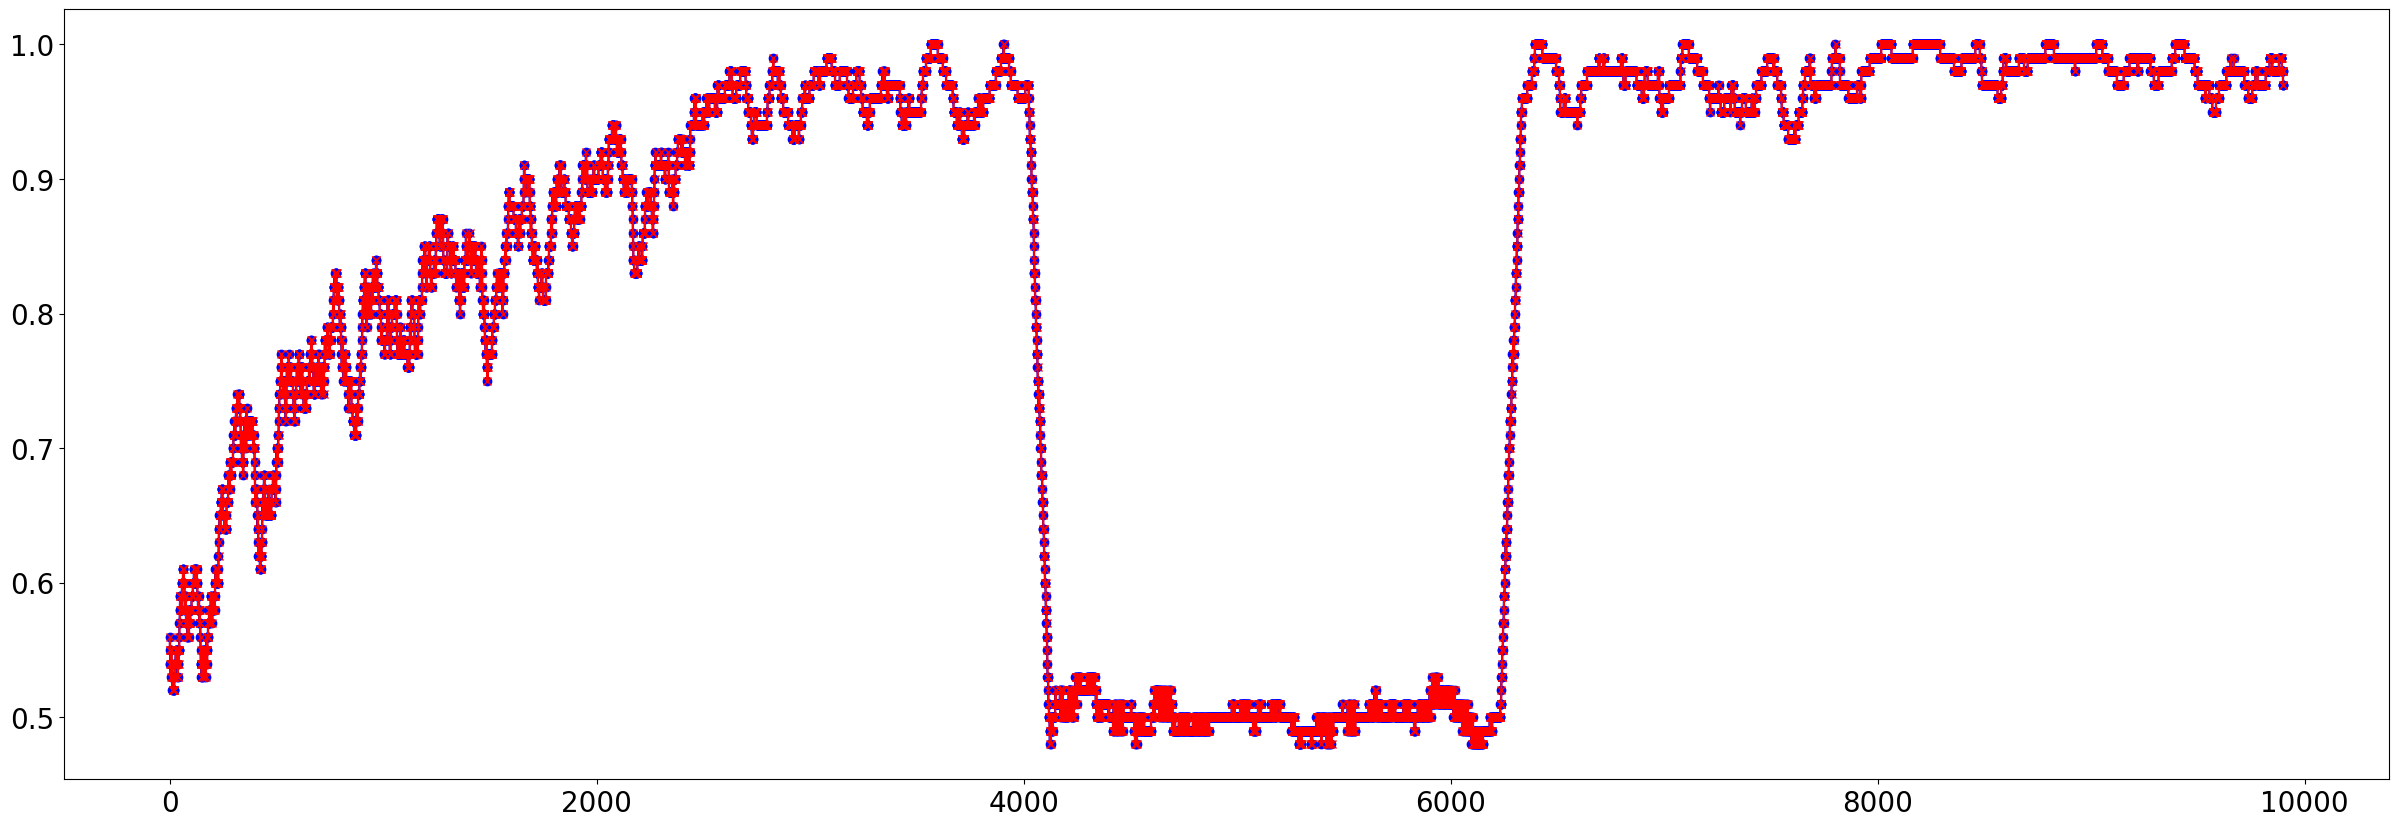

In [63]:
actions = np.array(actions)
plot(actions, 'Learning against Tit-for-Tat only')